# World Data League 2022

## 🎯 Challenge
**Semi-Finals**: Predicting a safety score for Women in Costa Rica

## Team: YODAS
Your Omnipotent DAta Scientists
## 👥 Authors

*   Cristiana Carpinteiro
*   Diogo Polónia
*   João Matos
*   João Pereira
*   Patrícia Rocha

# 📋 Table of Contents<a name="top"></a>

[Setup](#setup)

[Development](#dev)

1. [EDA](#eda)

2. [Create optimization grid](#grid)

3. [Feature Extraction](#feature_extraction)

4. [Correlation with number of crimes](#correlation)

5. [Create Final Score](#score)

6. [Crime Forecasting](#forecasting)

6. [Route Optimization for SafeMaps](#optimization)

7. [SafeMaps in Action](#safemaps)

8. [Impact Estimation](#impact)

[References](#ref)

[Appendix](#app)

## ⚙️ ***Setup***<a name="setup"></a>
[(back to top)](#top)

Install and import required libraries:

In [ ]:
!pip3 install geopandas
!pip3 install Dijkstar
#!pip install arcgis

In [ ]:
import dijkstar as dj
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import warnings

# from arcgis.geometry import Polygon as arcGIS_Polygon
from google.colab import drive
from matplotlib import rcParams
from os import listdir
from os.path import isfile, join
from pandas.core.common import SettingWithCopyWarning
from pyproj import Proj, transform
from scipy.stats import pearsonr
from shapely import wkt
from shapely.geometry import Polygon as shp_Polygon
from shapely.geometry import Point, LineString, shape
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from time import time
from tqdm.notebook import tqdm

warnings.filterwarnings(action='ignore')
pd.set_option('mode.chained_assignment', None)

Setup google drive:

In [ ]:
drive.mount('/content/drive/')
working_dir = '/content/drive/MyDrive/Semi-Finals'
os.chdir(working_dir)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
rcParams['figure.figsize'] = 16, 8
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.

## 💻 Development <a name="dev"></a>
[(back to top)](#top)

The development of our solution started with research on safety factors in cities. Some of the factors that are widely mentioned are $[1, 2]$:


*   ***Lighting (night)*** - if the lighting is enough for clear visibility
*   ***Openness*** - if you are able to see clearly in all directions
*   ***Visibility*** - if there are windows or entrances overlooking the place
*   ***People*** - if the place is crowded
*   ***Security*** - if there is police/reliable security within hailing distance
*   ***Public transport*** - if there is a metro or bus stop within 2 minutes walk
*   ***Gender usage*** - if the gender usage is well balanced

### 1. ***EDA*** <a name="eda"></a>
[(back to top)](#top)

Our EDA has the goal of curating a set of features that are indicators of women safety in cities, according to previous research. We started by exploring the datasets made available by the WDL organization.

Note: the ArcGIS files were converted to GeoPandas using a class that can be found in the Appendix.

***1. Geographical data regarding the canton of San José:***

In [ ]:
san_jose_districts = gpd.read_file('DATA/gpd/arcGIS_districts.geojson')

In [ ]:
def plot_feature(base_map, df, col, title):
  fig, ax = plt.subplots()
  base_map.plot(ax=ax, alpha=0.2)
  df.plot(column=col, legend=True, ax=ax)
  ax.set_title(title)
  ax.set_axis_off()

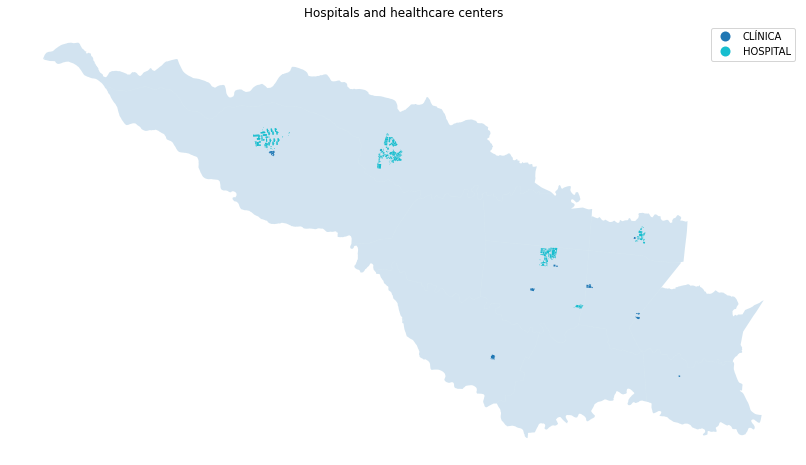

In [ ]:
gpd_health = gpd.read_file('DATA/gpd/arcGIS_healthcare.geojson')

# Filter by hospitals and healthcare centers
gpd_health = gpd_health[gpd_health.SUBCATEGORIA.isin(['HOSPITAL', 'CLÍNICA'])]

plot_feature(san_jose_districts, gpd_health, col='SUBCATEGORIA',
             title='Hospitals and healthcare centers')

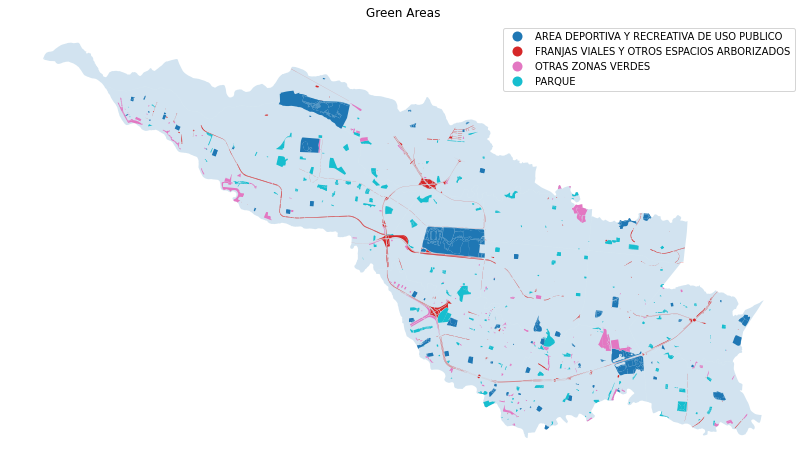

In [ ]:
gpd_green_areas = gpd.read_file('DATA/gpd/arcGIS_green_areas.geojson')

gpd_green_areas = gpd_green_areas[gpd_green_areas.CATEGORIA.isin(
    ['PARQUE', 'FRANJAS VIALES Y OTROS ESPACIOS ARBORIZADOS', 'OTRAS ZONAS VERDES', 'AREA DEPORTIVA Y RECREATIVA DE USO PUBLICO'])]

plot_feature(san_jose_districts, gpd_green_areas, col='CATEGORIA',
             title='Green Areas')

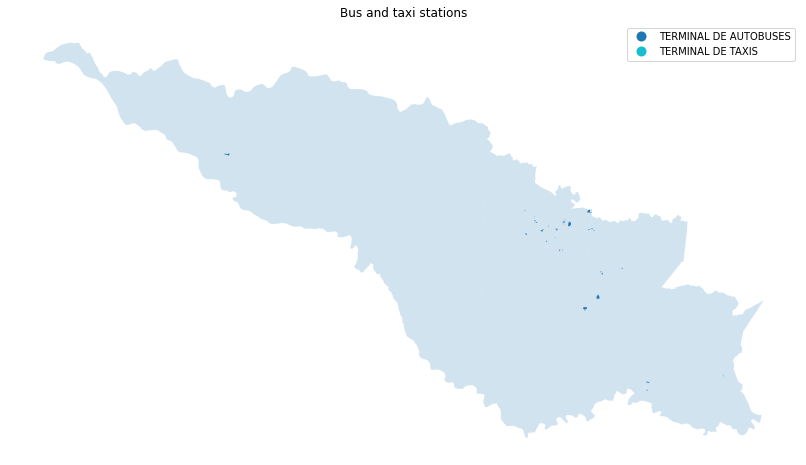

In [ ]:
gpd_communal_areas = gpd.read_file('DATA/gpd/arcGIS_communal_areas.geojson')

# Filter by bus and taxi stations
gpd_public_transport = gpd_communal_areas[gpd_communal_areas.CATEGORIA.isin(['TERMINAL DE TAXIS', 'TERMINAL DE AUTOBUSES'])]

plot_feature(san_jose_districts, gpd_public_transport, col='CATEGORIA',
             title='Bus and taxi stations')

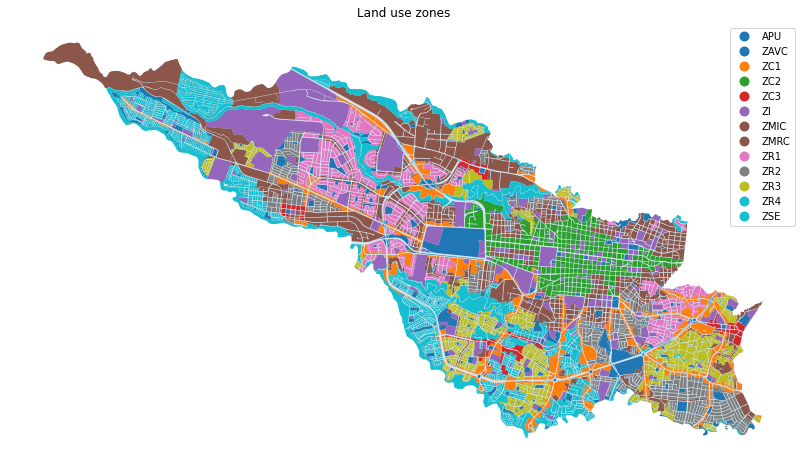

In [ ]:
gpd_zones = gpd.read_file('DATA/gpd/arcGIS_zonas.geojson')

plot_feature(san_jose_districts, gpd_zones, col='CATEGOUSO',
             title='Land use zones')

In [ ]:
gpd_zones_residential = gpd_zones[gpd_zones.CATEGOUSO.isin(['ZR1','ZR2','ZR3','ZR4', 'ZMRC'])]
gpd_zones_commercial = gpd_zones[gpd_zones.CATEGOUSO.isin(['ZC1','ZC2','ZC3', 'ZMRC'])]
gpd_zones_industrial = gpd_zones[gpd_zones.CATEGOUSO.isin(['ZMIC'])]
gpd_zones_institutional = gpd_zones[gpd_zones.CATEGOUSO.isin(['ZI'])]

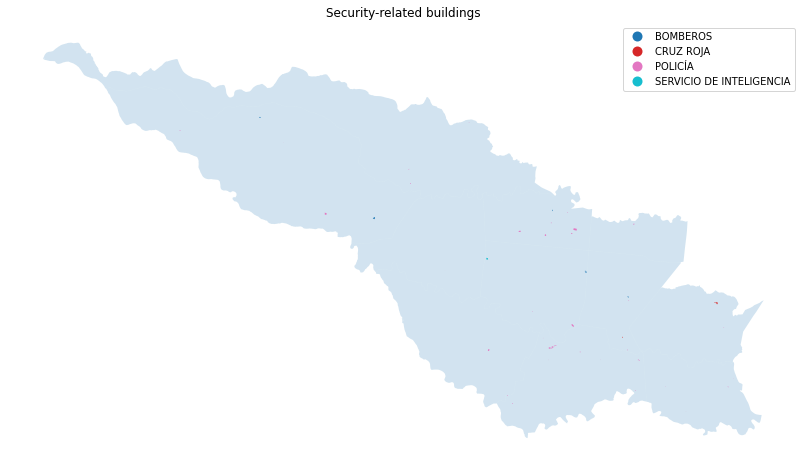

In [ ]:
gpd_security = gpd.read_file('DATA/gpd/arcGIS_security.geojson')

plot_feature(san_jose_districts, gpd_security, col='SUBCATEGORIA',
             title='Security-related buildings')

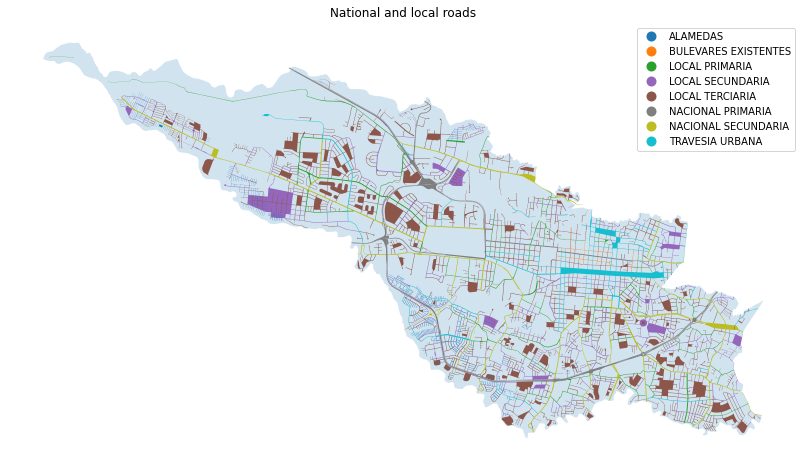

In [ ]:
gpd_roads = gpd.read_file('DATA/gpd/arcGIS_vialidad.geojson')

# Drop future roads, private roads, and places without data
gpd_roads = gpd_roads[gpd_roads.Tipo_Ruta.isin(
    ['ALAMEDAS', 'BULEVARES EXISTENTES', 'TRAVESIA URBANA',
     'LOCAL PRIMARIA', 'LOCAL SECUNDARIA', 'LOCAL TERCIARIA',
     'NACIONAL PRIMARIA', 'NACIONAL SECUNDARIA']
)]

plot_feature(san_jose_districts, gpd_roads, col='Tipo_Ruta',
             title='National and local roads')

In [ ]:
gpd_main_roads = gpd_roads[gpd_roads.Tipo_Ruta.isin(['BULEVARES EXISTENTES', 'LOCAL PRIMARIA', 'NACIONAL PRIMARIA'])]
gpd_secondary_roads = gpd_roads[gpd_roads.Tipo_Ruta.isin(['LOCAL SECUNDARIA', 'NACIONAL SECUNDARIA'])]
gpd_tertiary_roads = gpd_roads[gpd_roads.Tipo_Ruta.isin(['ALAMEDAS', 'LOCAL TERCIARIA'])]

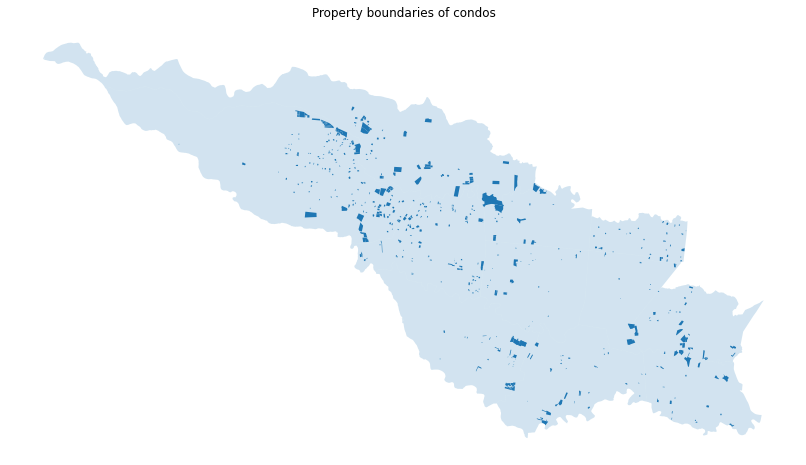

In [ ]:
gpd_condos = gpd.read_file('DATA/gpd/arcGIS_catasto_codominios.geojson')

plot_feature(san_jose_districts, gpd_condos, col=None,
             title='Property boundaries of condos')

***2. Demographic data regarding the canton of San José:***


In [ ]:
district_data = pd.read_csv('DATA/urbanalytica_datasets/district_data.csv')

In [ ]:
district_data['provincia'] = district_data['{Provincia, Canton, Distrito}'].apply(lambda x: x.strip('{}').split(',')[0].replace('"', '').strip())
district_data['canton'] = district_data['{Provincia, Canton, Distrito}'].apply(lambda x: x.strip('{}').split(',')[1].replace('"', '').strip())
district_data['distrito'] = district_data['{Provincia, Canton, Distrito}'].apply(lambda x: x.strip('{}').split(',')[2].replace('"', '').strip())
district_data = district_data.drop(columns=['Unnamed: 0', '{Provincia, Canton, Distrito}'])

In [ ]:
district_data = district_data[district_data.canton == 'SAN JOSE']

In [ ]:
demographics = district_data[
  ['distrito', 'Económica', 'Participación electoral', 'Salud', 'Educación', 
   'Seguridad', 'IDS 2017', 'Densidad de población', 'Relación hombres mujeres', 
   'Porcentaje de población no asegurada']
]

***3. Historical street harassment data regarding the canton of San José:***

In [ ]:
harassement = pd.read_csv('/content/drive/MyDrive/WDL/urbanalytica_datasets/costa_rica_street_harassement_english.csv')
#harassement = pd.read_csv('DATA/urbanalytica_datasets/urbanalytica_datasets/costa_rica_street_harassement_english.csv')
harassement.head(1)

,province,canton,district,public_prosecutors_office,sexual_harassement,exhibitionism,pursuit_or_cornering,production_of_audiovisual_material,sexual_harassement_law
0,Heredia,Heredia,Heredia,Fiscalía Heredia (Adjunta),1,10,3,0,15


In [ ]:
print(f'Number of reports = {len(harassement)}\nNumber of districts in this dataset =', str(len(harassement['district'].unique())))
print('Number of reports in San José canton =', str(len(harassement.loc[harassement['canton'] == 'San Jose'])))
print('Number of districts of San José canton in this dataset =', str(len(harassement.loc[harassement['canton'] == 'San Jose']['district'].unique())))

Number of reports = 56
Number of districts in this dataset = 42
Number of reports in San José canton = 6
Number of districts of San José canton in this dataset = 3


The original size of this dataset is very small (only 52 reports), and when filtered to only consider San José canton it only has 6 rows (from only 3 of the 11 districts of the canton), which makes it impossible to use in a relevant and valuable way.

***4. Historical crime data regarding the canton of San José:***

In [ ]:
crime = pd.read_csv('/content/drive/MyDrive/WDL/urbanalytica_datasets/costa_rica_crimes_english.csv')
#crime = pd.read_csv('DATA/urbanalytica_datasets/costa_rica_crimes_english.csv')
crime.head(1)

,Unnamed: 0,Crime,SubtypeCrime,Date,Time,SubtypeVictim,Age,Gender,Nationality,Province,Canton,District
0,0,ASSAULT,COLD WEAPON,08.01.22,06:00:00 - 08:59:59,LOTTERY SELLER [PERSON],>18 y/o,female,COSTA RICA,SAN JOSE,SAN JOSE,HOSPITAL


In [ ]:
total_crimes = len(crime)
crime = crime.loc[(crime['Canton'] == 'SAN JOSE') & (crime['District'] != 'DESCONOCIDO')]
print('Total crimes = {}\nTotal crimes in San José canton = {}'.format(total_crimes, len(crime)))

Total crimes = 648226
Total crimes in San José canton = 102842


After considering only the 11 districts of San José canton, the number of crime reports remains above 100 000, a considerable value. However, it is necessary to explore the types and subtypes of crimes, as well as victims, in order to only consider relevant data. The goal of ths solution is to help people, more specifically women, feeling more safe in the streets, so we will mostly consider crimes commited directly against people.

In [ ]:
crime['Crime'].value_counts()

ASSAULT              44638
THEFT                35639
ROBBERY               8598
VEHICLE VANDALISM     8141
VEHICLE THEFT         5217
HOMICIDE               609
Name: Crime, dtype: int64

As THEFT, VEHICLE VANDLISM AND VEHICLE THEFT are not directly against people, they will not be considered.

In [ ]:
crime = crime.loc[crime['Crime'].isin(['ASSAULT', 'ROBBERY', 'HOMICIDE'])]
print(f"Remaining crime reports = {len(crime)}")

Remaining crime reports = 53845


In [ ]:
crime['SubtypeCrime'].value_counts()

FIREARM                                18597
COLD WEAPON                             9904
OUTBURST                                6859
FORCE                                   5386
HITTING                                 4062
VERBAL INTIMIDATION                     2053
SUFFOCATION/STRANGULATION               1879
BREAKING AND ENTRY                      1042
IMMOBILIZATION                           962
ESCALATION                               611
OTHER OR UNDETERMINED                    596
CUT PADLOCKS                             534
BLINDS REMOVAL                           452
BREAKING WINDOWS                         353
REVENGE                                  166
NOT DETERMINED                           165
ARGUMENT/FIGHT                            75
FOR THE COMMISSION OF ANOTHER CRIME       52
USE OF GAS                                31
UNKNOWN                                   27
AVOIDING CRIMINAL ACTIVITY                18
DOMESTIC VIOLENCE                         14
FEMICIDE  

All crimes not directly related to people will be removed.

In [ ]:
crime = crime.loc[crime['SubtypeCrime'].isin(['COLD WEAPON', 'FIREARM', 'OUTBURST', 'SUFFOCATION/STRANGULATION', 'HITTING', 'IMMOBILIZATION', 'VERBAL INTIMIDATION', 'ESCALATION', 'ARGUMENT/FIGHT', 'DOMESTIC VIOLENCE', 'FEMICIDE'])]
print(f"Remaining crime reports = {len(crime)}")

Remaining crime reports = 45021


Also, the victime type reveals that there are still crimes directly related to vehicles or buildings, which will be removed.

In [ ]:
crime['SubtypeVictim'].value_counts()

PEDESTRIAN [PERSON]                                   31433
CAR [VEHICLE]                                          1913
NOT APPLICEABLE [HOUSING]                              1162
PASSENGER OF PUBLIC TRANSPORT [PERSON]                 1142
PUBLIC SERVICE/LEGAL OR ILLEGAL TAXI/BUS [VEHICLE]     1120
                                                      ...  
PERSON WITHOUT HOUSING [PERSON]                           2
UNCLASSIFIED [BUILDING]                                   1
MARKET [BUILDING]                                         1
AQUATIC [VEHICLE]                                         1
CAR RENTAL [BUILDING]                                     1
Name: SubtypeVictim, Length: 79, dtype: int64

In [ ]:
crime = crime.loc[crime['SubtypeVictim'].str.contains('PERSON')]
print(f"Remaining crime reports = {len(crime)}")

Remaining crime reports = 35655


The gender is also a relevant point in this dataset, so it may be useful to filter the data to only consider women or men. From the analysis, it is clear that the crimes against women that are reported are just half from the crimes against men that are reported.

In [ ]:
crime['Gender'].value_counts()

male       23504
female     11668
unknown      483
Name: Gender, dtype: int64

Example of filtering the dataset by gender

In [ ]:
#crime = crime.loc[crime['Gender'].isin(['male', 'female', 'unknown'])]
crime = crime.loc[crime['Gender'].isin(['female'])]

**Create function for automatic crime dataset cleaning**

The goal of the following function is to facilitate future usage of this dataset.

In [ ]:
def clean_crime_data(gender='all'):

  # Clean crime dataset
  # Args:
  ### gender - 'all' for both genders, 'female' for just women and 'male' for just men (default is 'all')
  # Returns:
  ### Dataframe with crime dataset cleaned

  crime = pd.read_csv('/content/drive/MyDrive/WDL/urbanalytica_datasets/costa_rica_crimes_english.csv')
  crime = crime.loc[(crime['Canton'] == 'SAN JOSE') & (crime['District'] != 'DESCONOCIDO') & (crime['Crime'].isin(['ASSAULT', 'ROBBERY', 'HOMICIDE'])) & (crime['SubtypeCrime'].isin(['COLD WEAPON', 'FIREARM', 'OUTBURST', 'SUFFOCATION/STRANGULATION', 'HITTING', 'IMMOBILIZATION', 'VERBAL INTIMIDATION', 'ESCALATION', 'ARGUMENT/FIGHT', 'DOMESTIC VIOLENCE', 'FEMICIDE'])) & (crime['SubtypeVictim'].str.contains('PERSON'))]
  
  if gender == 'female':
    crime = crime.loc[crime['Gender'].isin(['female'])]
  elif gender == 'male':
    crime = crime.loc[crime['Gender'].isin(['male'])]
  elif gender == 'all':
    crime = crime.loc[crime['Gender'].isin(['male', 'female'])]
  else:
    raise Exception("Invalid value for gender: 'all', 'male' or 'female'")

  return crime

### 2. ***Create optimization grid***<a name="grid"></a>
[(back to top)](#top)

We created a grid of $N \times N$ cells and used it to divide the canton of San José into geographical zones, where each zone will be associated with a curated set of features. The granularity of the grid can be adjusted according to the needs (the zone size could be set to district or block level - however, if the granularity is too high, then we would likely have to exclude zones that overlap with buildings or other private places).

In [ ]:
# Define boundaries of the grid
xmin, ymin, xmax, ymax = -84.2, 9.8, -84.0, 10.0

wide, length = xmax - xmin, ymax - ymin
n_cols = 300
n_rows = 300

cols = list(np.arange(xmin, xmax + wide/n_cols, wide/n_cols))
rows = list(np.arange(ymin, ymax + length/n_rows, length/n_rows))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(shp_Polygon([(x,y), (x+wide/n_cols, y), (x+wide/n_cols, y+length/n_rows), (x, y+length/n_rows)]))

grid = gpd.GeoDataFrame({'geometry': polygons})

for district, name in zip(list(san_jose_districts['geometry']), list(san_jose_districts['Nombre'])):
  grid.loc[grid.intersects(district), 'district'] = name

san_jose_districts_grid = grid[grid['district'].notna()].reset_index(drop=True)

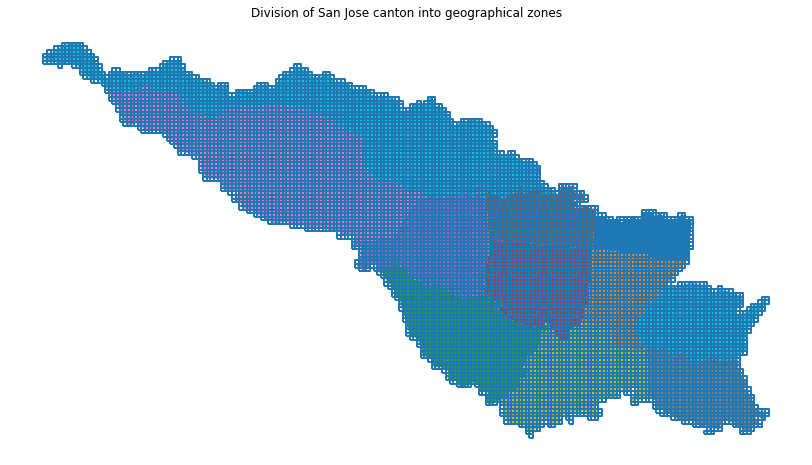

In [ ]:
fig, ax = plt.subplots()
san_jose_districts.plot(column='Nombre', ax=ax)
san_jose_districts_grid.boundary.plot(ax=ax)
ax.set_title('Division of San Jose canton into geographical zones')
ax.set_axis_off()

In this coordinate system, $1 km$<sup>2</sup> $\approx$ $8.2e$<sup>$-5$</sup> area units. Each square has approximately 74 meters of width.

### 3. ***Feature Extraction***<a name="feature_extraction"></a>
[(back to top)](#top)

We developed the following methods to calculate a set of features for each geographical zone:

In [ ]:
def get_distance_to_grid(grid, gpd, name):
  for idx, zone in grid.iterrows():
    center = zone.geometry.centroid
    min_distance = gpd.geometry.distance(center).min()
    grid.loc[idx, 'dist_nearest_'+ name] = min_distance

  return grid

def check_intersection_grid(grid, gpd, name): 
  for idx, zone in grid.iterrows():
    if gpd.intersects(zone.geometry).any():
      grid.loc[idx, 'intersects_'+name] = 1
    else:
      grid.loc[idx, 'intersects_'+name] = 0
      
  return grid

def geopandas_plot(df, col, title):
  fig, ax = plt.subplots()
  df.plot(column=col, markersize=50, legend=True, ax=ax)
  ax.set_title(title)
  ax.set_axis_off()

***Urban Planning Features:***

In the literature, permeability of a space is defined as the ease of movement between two places. Alternative routes to reach from point A to point B gives an opportunity to choose the safest one $[2]$. To get the permeability for each zone, we calculated the number intersections with roads:

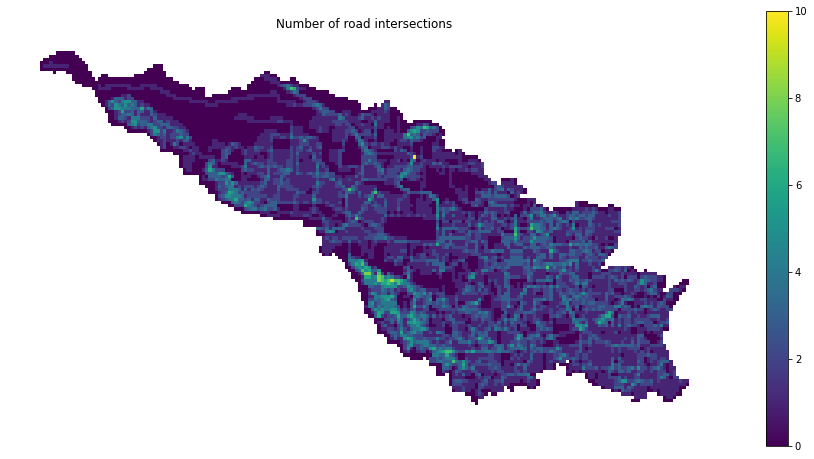

In [ ]:
for idx, zone in san_jose_districts_grid.iterrows():
  num_intersections = gpd_roads.intersects(zone.geometry).sum()
  san_jose_districts_grid.loc[idx, 'num_road_intersections'] = num_intersections

geopandas_plot(san_jose_districts_grid, col='num_road_intersections', title='Number of road intersections')

A good safety indicator is the distance to the nearest security-related building. A greater visibility of police in public spaces could positively impact the feeling of safety among the citizens. The proximity to hospitals can be seen as positive as well, since hospitals and healthcare centers are usually open all day:

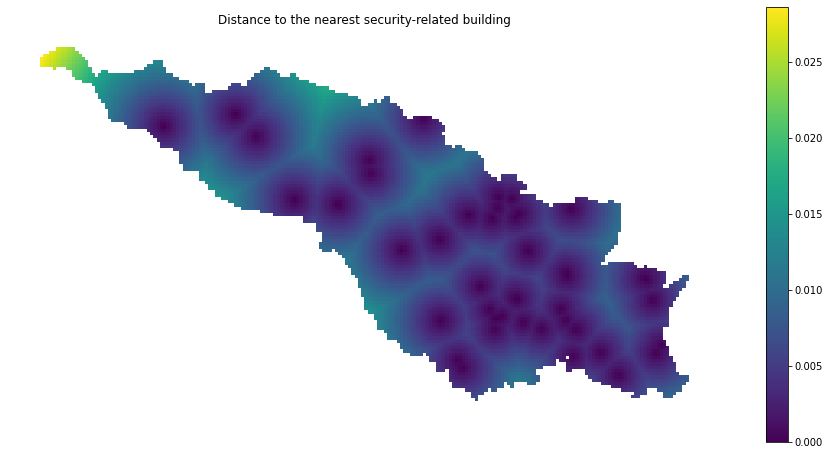

In [ ]:
san_jose_districts_grid = get_distance_to_grid(san_jose_districts_grid, gpd_security, 'security')
geopandas_plot(san_jose_districts_grid, col='dist_nearest_security', title='Distance to the nearest security-related building')

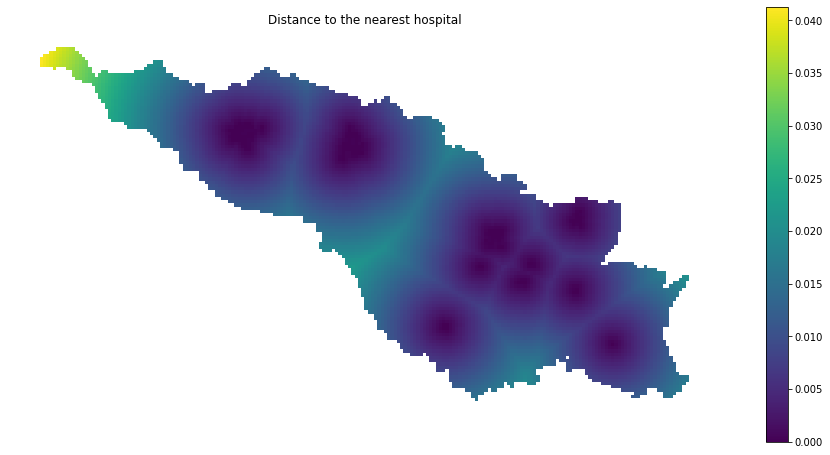

In [ ]:
san_jose_districts_grid = get_distance_to_grid(san_jose_districts_grid, gpd_health, 'hospital')
geopandas_plot(san_jose_districts_grid, col='dist_nearest_hospital', title='Distance to the nearest hospital')

Another key indicator is the proximity to public transport stations. However, according to the literature there are mixed opinions regarding public transport: public transport ensures that all citizens are able to travel, including more vulnerable groups. On the other hand, there are a lot of reports of sexual harassment in public transport $[5]$.

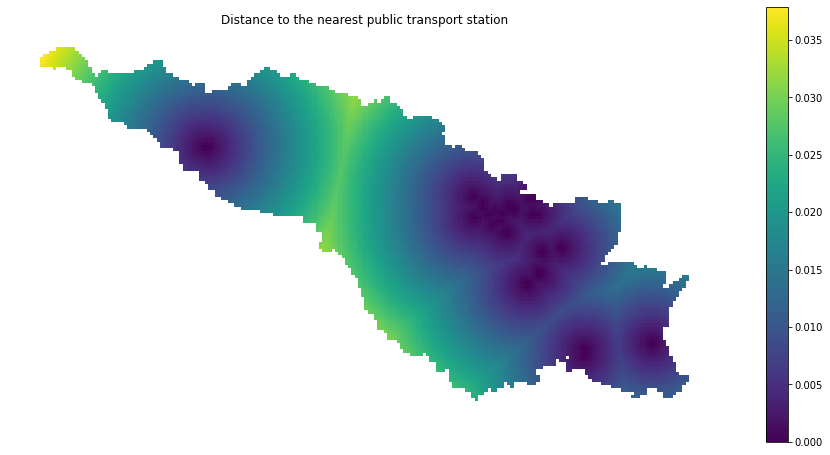

In [ ]:
san_jose_districts_grid = get_distance_to_grid(san_jose_districts_grid, gpd_public_transport, 'public_transport')
geopandas_plot(san_jose_districts_grid, col='dist_nearest_public_transport', title='Distance to the nearest public transport station')

The proximity to condos or the intersection with residential areas can also positively influence the feeling of safety in public spaces from the perspective of visibility, i.e. if there are windows or entrances overlooking the area: 

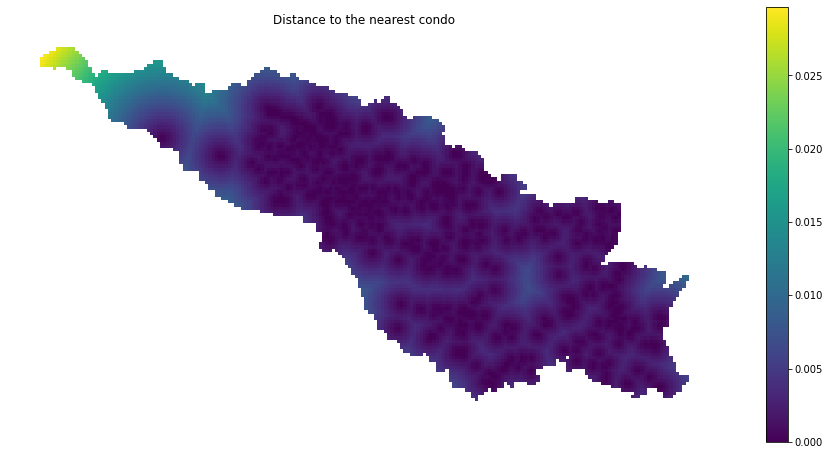

In [ ]:
san_jose_districts_grid = get_distance_to_grid(san_jose_districts_grid, gpd_condos, 'condo')
geopandas_plot(san_jose_districts_grid, col='dist_nearest_condo', title='Distance to the nearest condo')

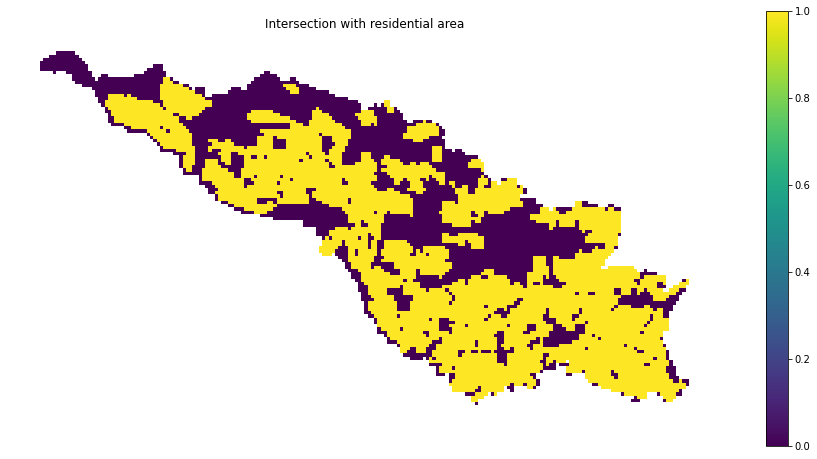

In [ ]:
san_jose_districts_grid =  check_intersection_grid(san_jose_districts_grid, gpd_zones_residential, 'residential_area')
geopandas_plot(san_jose_districts_grid, col='intersects_residential_area', title='Intersection with residential area')

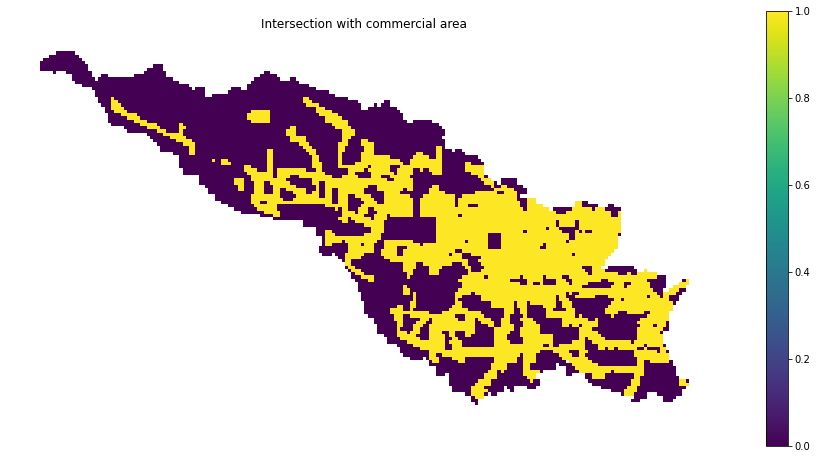

In [ ]:
san_jose_districts_grid =  check_intersection_grid(san_jose_districts_grid, gpd_zones_commercial, 'commercial_area')
geopandas_plot(san_jose_districts_grid, col='intersects_commercial_area', title='Intersection with commercial area')

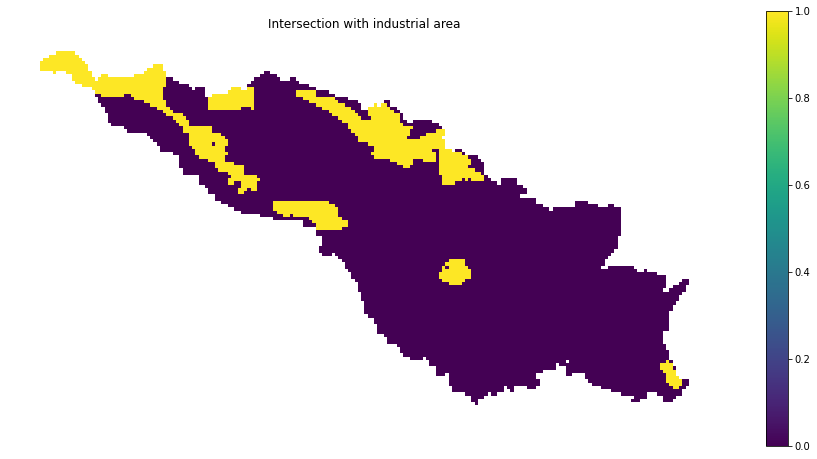

In [ ]:
san_jose_districts_grid =  check_intersection_grid(san_jose_districts_grid, gpd_zones_industrial, 'industrial_area')
geopandas_plot(san_jose_districts_grid, col='intersects_industrial_area', title='Intersection with industrial area')

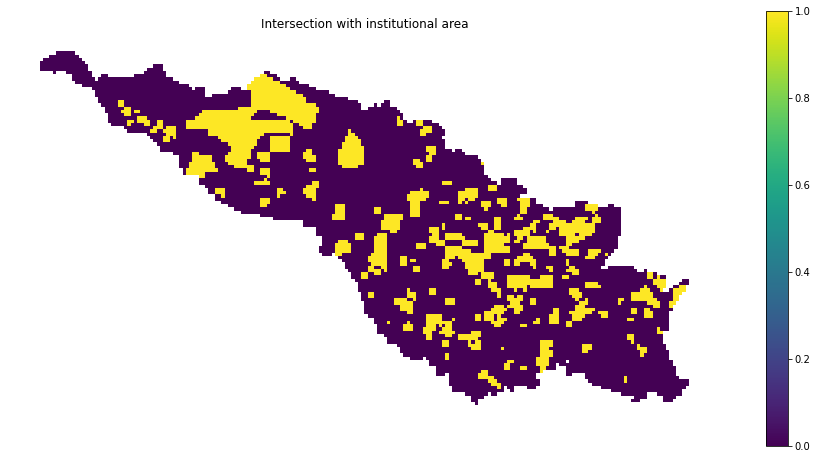

In [ ]:
san_jose_districts_grid =  check_intersection_grid(san_jose_districts_grid, gpd_zones_institutional, 'institutional_area')
geopandas_plot(san_jose_districts_grid, col='intersects_institutional_area', title='Intersection with institutional area')

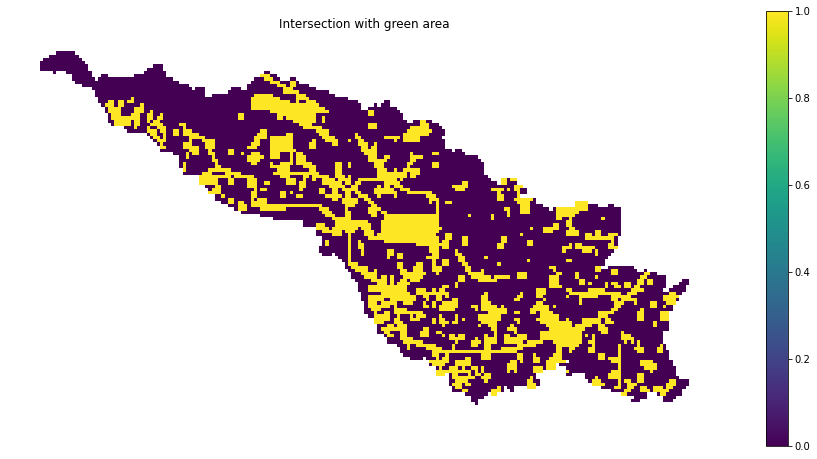

In [ ]:
san_jose_districts_grid =  check_intersection_grid(san_jose_districts_grid, gpd_green_areas, 'green_area')
geopandas_plot(san_jose_districts_grid, col='intersects_green_area', title='Intersection with green area')

We also considered the intersection with main, secondary, or tertiary roads. Main roads are likely to have more people circulating compared to tertiary roads. This factor can also be correlated to street lighting: main roads are usually well lit.

Once again, this factor has mixed opinions: *\"Research has also shown that **women find both completely deserted places and very crowded places unsafe**. The likely reasoning is that in deserted places, women fear sexual or violent assault, whereas in crowded places, the risk of different forms of sexual harassment increases, as the crowd provides opportunities and anonymity $[1]$.\"*

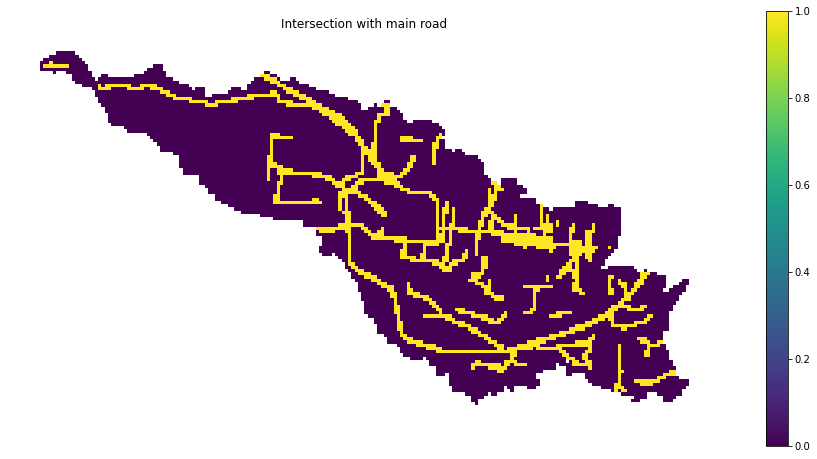

In [ ]:
san_jose_districts_grid =  check_intersection_grid(san_jose_districts_grid, gpd_main_roads, 'main_road')
geopandas_plot(san_jose_districts_grid, col='intersects_main_road', title='Intersection with main road')

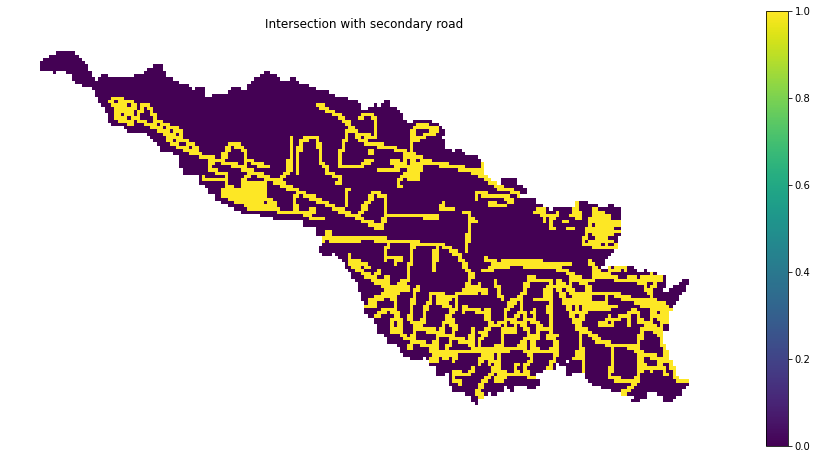

In [ ]:
san_jose_districts_grid =  check_intersection_grid(san_jose_districts_grid, gpd_secondary_roads, 'secondary_road')
geopandas_plot(san_jose_districts_grid, col='intersects_secondary_road', title='Intersection with secondary road')

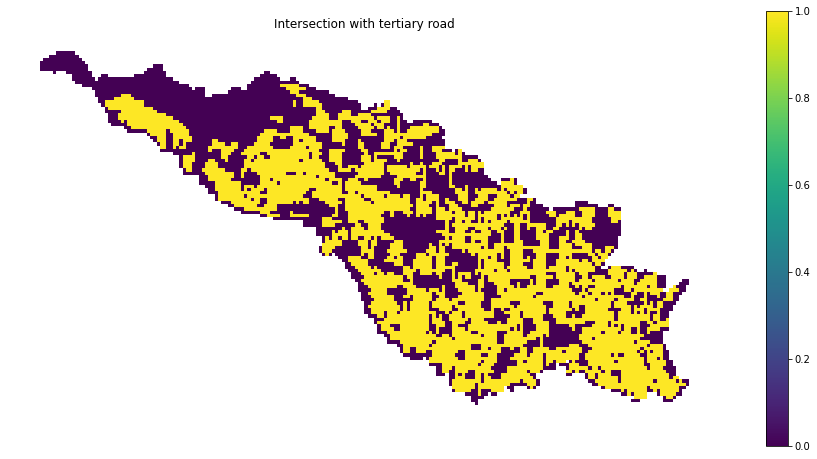

In [ ]:
san_jose_districts_grid =  check_intersection_grid(san_jose_districts_grid, gpd_tertiary_roads, 'tertiary_road')
geopandas_plot(san_jose_districts_grid, col='intersects_tertiary_road', title='Intersection with tertiary road')

***Demographic Features***:

In [ ]:
demographics.rename(columns={'distrito': 'district'}, inplace=True)
san_jose_districts_grid = san_jose_districts_grid.merge(demographics, on='district')

### 4. ***Correlation with number of crimes***<a name="correlation"></a>
[(back to top)](#top)

To create the final score, we needed to understand the impact of each feature on the population. One of our strategies consisted of calculating the correlation between each feature and the number of crimes.

However, we are aware that using historical crime data for risk assessment tools and finding statistical ***correlations*** is nowhere near the same as ***causations***. For instance, a correlation between low income and a higher crime rate does not mean low income causes crime, and must be taken with a fine grain of salt.

In [ ]:
aux_san_jose_districts_grid = san_jose_districts_grid.copy()
aux_san_jose_districts_grid.rename(columns={'district': 'District'}, inplace=True)

Merge grid with the crime dataset:

In [ ]:
costa_rica_crimes = pd.read_csv('DATA/urbanalytica_datasets/costa_rica_crimes_english.csv').drop('Unnamed: 0', axis=1)

san_jose_crimes = costa_rica_crimes[
  (costa_rica_crimes.Canton == 'SAN JOSE') & (costa_rica_crimes.District != 'DESCONOCIDO')
].reset_index(drop=True)

In [ ]:
# Drop data from 2020 to now (COVID)
san_jose_crimes['Date'] = pd.to_datetime(san_jose_crimes['Date'], format='%d.%m.%y')
san_jose_crimes['Year'] = san_jose_crimes['Date'].apply(lambda x: x.year)
san_jose_crimes = san_jose_crimes[san_jose_crimes.Year < 2020]

In [ ]:
crimes_per_district = san_jose_crimes[['Crime', 'District']].groupby('District').count()

In [ ]:
crimes_per_district = crimes_per_district.merge(aux_san_jose_districts_grid, on='District')

Calculate ***Pearson's correlation coefficient*** between the number of crimes and each feature:

In [ ]:
pearson_coeff = dict()
for feature in crimes_per_district.columns[3:]:
  coeff, _ = pearsonr(x=crimes_per_district['Crime'].values, y=crimes_per_district[feature].values)
  pearson_coeff[feature] = coeff

In [ ]:
sorted(pearson_coeff.items(), key=lambda x: x[1])

[('dist_nearest_public_transport', -0.514510960171709),
 ('Participación electoral', -0.497411843948992),
 ('Seguridad', -0.4074124713817381),
 ('dist_nearest_hospital', -0.38592537108817265),
 ('Económica', -0.3007966195037537),
 ('dist_nearest_security', -0.3005361457696877),
 ('IDS 2017', -0.2965476485284055),
 ('intersects_industrial_area', -0.1440818499233292),
 ('dist_nearest_condo', -0.12579190752783004),
 ('Salud', -0.11916131334910045),
 ('intersects_green_area', -0.10624298248595104),
 ('intersects_secondary_road', -0.03987512086317708),
 ('intersects_residential_area', -0.02371619696192162),
 ('Educación', 0.05122225123544872),
 ('Densidad de población', 0.05533526382127411),
 ('intersects_main_road', 0.06812451165422047),
 ('intersects_institutional_area', 0.10988400857599515),
 ('num_road_intersections', 0.12384871183479368),
 ('intersects_tertiary_road', 0.13010399994522526),
 ('Porcentaje de población no asegurada', 0.18905536922140093),
 ('Relación hombres mujeres', 0.3

This approach is flawed since we have different levels of granularity for features and the historical crime data, and we only have 11 data points in the crime dataset (corresponding to the 11 districts). For that reason, the degree of confidence in these correlations and their statistical significance is low.

Nevertheless, some of these correlations are in line with the literature.

#### ***Survey***

To ensure a robust score that reflects the population's perception of safety, we sent a ***survey*** questioning people which demographic and urban planning factors they would intuitively say to have more impact on their safety (in a positive or negative way). Based on ***153 answers***, we extracted a weight for each feature. The answers to the form and treated data can be found [here](https://docs.google.com/spreadsheets/d/121sgT_HT1M-H0IBbdAVYz8uFIkfx5I4iTlZyjUt2TVQ/edit?usp=sharing).




Since our goal is to create a route optimization tool, environmental/urban design factors are more important. In fact, *\"the configuration of the street network was associated with the spatial distribution of outdoor serious violence $[4]$.\"* For this reason, we decided to assign different weights to demographic ($30\%$) and urban planning features ($70\%$).

In [ ]:
feature_names = sorted([feature for feature in crimes_per_district.columns if feature not in ['District', 'Crime', 'geometry']])
pearson_coeff = pearson_coeff.values()
survey_coeff = [0.1699, -0.5294, -0.9314, -0.7451, -0.5196, 0.4608, 0.3007, -0.8758, -0.7941, -0.2908, 0.4673, 0.4510, 0.4248, -0.4216, -0.3660, 0.2059, -0.3627, -0.2745, -0.3693, 0.0294, 0.1797, 0.0458]

impact = pd.DataFrame(
    {
      'feature': feature_names,
      'pearson_coefficient': pearson_coeff,
      'survey_coefficient': survey_coeff
    }
)

# Features at district level (same granularity as crime data)
impact['is_district'] = 0
impact.loc[impact['feature'].isin(demographics.columns.tolist()), 'is_district'] = 1

# Combine results from the survey and Pearson's correlation
impact['coefficient'] = impact['pearson_coefficient'] * 0.5 + impact['survey_coefficient'] * 0.5

We also added some features extracted from the historical crime data and assigned them a high importance:

In [ ]:
# FEATURE ENGINEERING FROM CRIME DATASET

# 1. Obtain the number of crimes for each month of each year, per district

def obtain_monthly_crimes(gender):

  crime = clean_crime_data(gender=gender)

  crime = crime[['Date', 'District']].copy()
  crime['Date'] =  pd.to_datetime(crime['Date'], format='%d.%m.%y')
  crime['Month'] = crime['Date'].apply(lambda x: x.month)
  crime['Year'] = crime['Date'].apply(lambda x: x.year)
  crime['Day'] = crime['Date'].apply(lambda x: x.day)
  crime = crime.drop(columns=['Date'])
  crime_month = crime.groupby(['District', 'Year', 'Month']).count().reset_index().rename(columns={'Day': 'Num crimes'})

  return crime_month

# 2. Average crimes per month (for each district) - all genders
# The goal is to obtain a dataframe with one row per district, and for each district the average number of crimes per month normalized by population density.

crime_month = obtain_monthly_crimes(gender='all')

crime_month_avg = crime_month[['District', 'Num crimes']].copy()
crime_month_avg = crime_month_avg.groupby('District').mean().reset_index()
dens = demographics[['distrito', 'Densidad de población']].rename(columns={'distrito': 'District', 'Densidad de población': 'population_density'})
crime_month_avg = crime_month_avg.merge(dens, on='District')
crime_month_avg['Num crimes normalized'] = crime_month_avg.apply(lambda row: row['Num crimes'] / row['population_density'], axis=1)

# 3. Average crimes per month (for each district) - female only 
# The goal is to obtain a dataframe with one row per district, and for each district the average number of crimes per month for which the victim was a woman.

crime_month_female = obtain_monthly_crimes(gender='female')

crime_month_avg_female = crime_month_female[['District', 'Num crimes']].copy()
crime_month_avg_female = crime_month_avg_female.groupby('District').mean().reset_index()

# 4. Merge the all genders and female datasets

crime_month_avg_female = crime_month_avg_female[['District', 'Num crimes']].rename(columns={'Num crimes': 'Num female crimes'})

crimes_month_and_ratio_women = crime_month_avg.merge(crime_month_avg_female, on='District')

crimes_month_and_ratio_women['ratio women/total'] = crimes_month_and_ratio_women.apply(lambda row: row['Num female crimes']/row['Num crimes'], axis=1)
crimes_month_and_ratio_women[['District', 'Num crimes normalized', 'ratio women/total']].to_csv('crimes_ratio_women.csv', index=False)
crimes_month_and_ratio_women.head(1)

,District,Num crimes,population_density,Num crimes normalized,Num female crimes,ratio women/total
0,CARMEN,21.067568,1813.422819,0.011618,7.331081,0.347979


In [ ]:
crime_features = pd.DataFrame(data={
    'feature': ['Num crimes normalized', 'ratio women/total'],
    'coefficient': [impact['coefficient'].max(), impact['coefficient'].max()],
    'is_district': [1, 1]
})

impact = pd.concat([impact, crime_features], axis=0)

In [ ]:
# Assign more weight to urban planning factors
impact.loc[impact['is_district'] == 1, 'coefficient'] = impact.loc[impact['is_district'] == 1, 'coefficient'] * 0.3
impact.loc[impact['is_district'] == 0, 'coefficient'] = impact.loc[impact['is_district'] == 0, 'coefficient'] * 0.7

# Scale importance between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
impact['coefficient_scaled'] = scaler.fit_transform(np.array(impact['coefficient']).reshape(impact.shape[0], 1))

In [ ]:
impact.sort_values('coefficient_scaled')

,feature,pearson_coefficient,survey_coefficient,is_district,coefficient,coefficient_scaled
14,intersects_green_area,-0.497412,-0.3660,0,-0.302194,-1.000000
13,intersects_commercial_area,-0.300797,-0.4216,0,-0.252839,-0.801151
17,intersects_main_road,-0.407412,-0.2745,0,-0.238669,-0.744064
18,intersects_residential_area,-0.296548,-0.3693,0,-0.233047,-0.721410
2,Educación,-0.385925,-0.9314,1,-0.197599,-0.578593
3,IDS 2017,-0.514511,-0.7451,1,-0.188942,-0.543714
7,Salud,-0.144082,-0.8758,1,-0.152982,-0.398837
9,dist_nearest_condo,-0.106243,-0.2908,0,-0.138965,-0.342362
1,Económica,-0.300536,-0.5294,1,-0.124490,-0.284045
16,intersects_institutional_area,0.051222,-0.3627,0,-0.109017,-0.221705


### 5. ***Create Final Score***<a name="score"></a>
[(back to top)](#top)

Our danger score will be used to suggest the safest path between two points. First, we scaled the features using standard scaling:

In [ ]:
# Merge crime features
aux_san_jose_districts_grid = aux_san_jose_districts_grid.merge(crimes_month_and_ratio_women, on='District')
features = aux_san_jose_districts_grid.drop(columns=['District', 'geometry']).columns.tolist()

meta = aux_san_jose_districts_grid[['District', 'geometry']]
aux_grid = aux_san_jose_districts_grid.drop(columns=['District', 'geometry'])

# Scale all features
scaler = StandardScaler()
aux_grid = scaler.fit_transform(np.array(aux_grid))

grid = pd.DataFrame(aux_grid, columns=features)
grid = pd.concat([meta, grid], axis=1)

The final score is a linear combination of all features weighted by their importance, as defined in the previous section:

In [ ]:
def create_score(row):
  feature_names = impact.feature.tolist()
  weighted_features = row[feature_names].values * impact.coefficient_scaled.values
  score = sum(weighted_features)

  return score

In [ ]:
grid['danger_score'] = grid.apply(create_score, axis=1)

***Plot final score:***

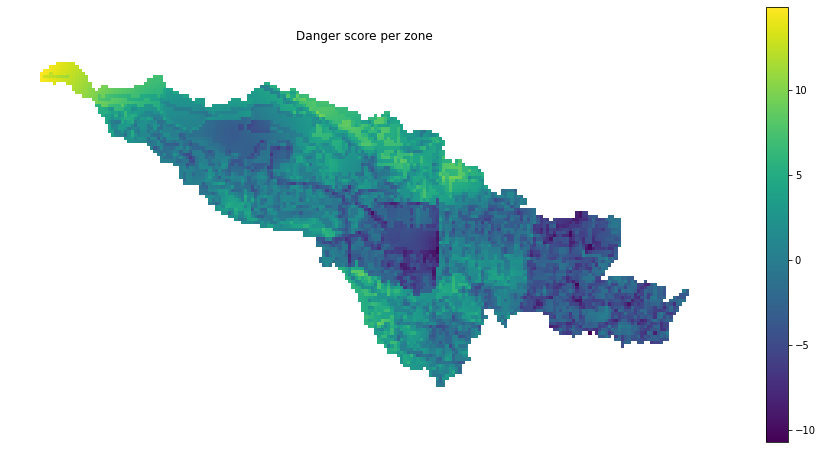

In [ ]:
fig, ax = plt.subplots()
grid.plot(column='danger_score', ax=ax, legend=True)
ax.set_title('Danger score per zone')
ax.set_axis_off()

### 6. ***Crime Forecasting***<a name="forecasting"></a>
[(back to top)](#top)

#### Process crime data for forecasting

Open and clean crime data, get datetime of first and last records

In [ ]:
crime = clean_crime_data(gender='all')
crime = crime[['Date', 'District']]
crime['Date'] =  pd.to_datetime(crime['Date'], format='%d.%m.%y')

print("First date: {}\nLast date: {}".format(crime['Date'].min(), crime['Date'].max()))

First date: 2010-01-01 00:00:00
Last date: 2022-04-14 00:00:00


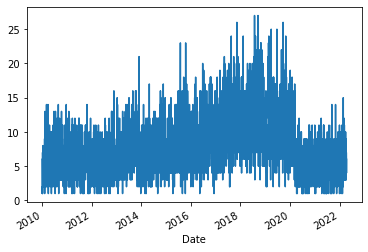

In [ ]:
crime.groupby('Date').count()['District'].plot()

The COVID-19 pandemic made the crime rates drop considerably in 2020. Because the crime behaviour was not natural after the start of the pandemic and still not recovered its usual values, the data will be filtered to only include records from before 2020.

In [ ]:
def process_for_forecasting(district, time_range):

  # Args:
  #district - one of the 11 districts of San José canton
  #time_range - Month, Quarter or Week

  time_col = f'year_{time_range.lower()}'

  crime = clean_crime_data(gender='all')
  crime = crime[['Date', 'District']]
  crime['Date'] =  pd.to_datetime(crime['Date'], format='%d.%m.%y')

  crime = crime.loc[crime['Date']<datetime.datetime(2020,1,1)]

  crime['Year'] = crime['Date'].apply(lambda x: x.year)

  if time_range == 'Month':
    crime[time_range] = crime['Date'].apply(lambda x: x.month)
    LAG = 12
    TEST = 12
  elif time_range == 'Quarter':
    crime[time_range] = crime['Date'].apply(lambda x: x.quarter)
    LAG = 4
    TEST = 8
  elif time_range == 'Week':
    crime[time_range] = crime['Date'].apply(lambda x: x.weekofyear)
    LAG = 52
    TEST = 52
  else:
    pass
  
  crime['Day'] = crime['Date'].apply(lambda x: x.day)

  crime = crime.drop(columns=['Date'])

  crime_month = crime.groupby(['District', 'Year', time_range]).count().reset_index().rename(columns={'Day': 'Num crimes'})
  crime_month = crime_month.loc[~((crime_month['Year'] == 2022) & (crime_month[time_range] == 2))]

  data = crime_month.loc[crime_month['District'] == district].copy()
  data[time_col] = data.apply(lambda row: str(row['Year']) + '_' + str(row[time_range]), axis=1)
  data = data.reset_index().drop(columns=['index', 'District', 'Year', time_range]).sort_values(by=time_col).reset_index().drop(columns=['index'])
  
  return TEST, LAG, time_col, data

In [ ]:
_, _, time_col, data = process_for_forecasting('CATEDRAL', 'Quarter')
print(len(data))
data.head(3)

40


,Num crimes,year_quarter
0,72,2010_1
1,83,2010_2
2,93,2010_3


In [ ]:
def plot_crime_evolution(district, time_range):
  data = process_for_forecasting(district, time_range)[3].reset_index()
  fig, ax = plt.subplots()
  sns.lineplot(x='index', y='Num crimes', data=data, ax=ax)
  ax.set_title(district)
  ax.set_xlabel('Quarter')

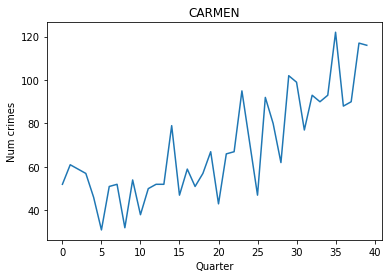

In [ ]:
for dist in crime_month['District'].unique():
  plot_crime_evolution(dist, 'Quarter')
  break

#### Create Crime Forecasting Class

In [ ]:
class CrimeForecasting():

  def __init__(self, district, time_range):

    print(district)

    self.district = district
    self.time_range = time_range

    self.test_start_idx, self.lag, self.time_col, self.data = process_for_forecasting(self.district, self.time_range)

    self.data = self.data.drop(columns=[self.time_col])

    self.train_df = self.data.iloc[:len(self.data)-self.test_start_idx]
    self.test_df = self.data.iloc[len(self.data)-self.test_start_idx:]

    try:
      self.train_df = self.train_df.set_index(self.time_col)
      self.test_df = self.test_df.set_index(self.time_col)
    except:
      pass
    
    print("\nNumber of days in train data = {}\nNumber of days in test data = {}".format(len(self.train_df), len(self.test_df)))

  def plot_data(self, only_test=False):

    if not only_test:
      plt.plot(self.train_df.index, self.train_df['Num crimes'], c='black')
    plt.plot(self.test_df.index, self.test_df['Num crimes'], c='red')

  def show_seasonal_decompose(self):

    result = seasonal_decompose(self.train_df, model='additive', freq=self.lag)

    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(15, 12)
    plt.show()

  def test_stationarity(self, data=None, cutoff=0.01):

    window = self.lag

    if data is None:
      timeseries = self.train_df['Num crimes']
    else:
      timeseries = data

    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 5)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

  def make_non_stationary(self):

    self.first_diff = self.train_df['Num crimes'] - self.train_df['Num crimes'].shift(1)
    self.first_diff = self.first_diff.dropna(inplace = False)
    self.test_stationarity(self.first_diff)

  def seasonality_analysis(self):

    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(self.train_df['Num crimes'], lags=self.lag, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(self.train_df['Num crimes'], lags=self.lag, ax=ax2)

  def train_and_test_model(self, model='arima', order=(1,1,0)):

    if model == 'sarima':

      model = SARIMAX(self.train_df['Num crimes'], order = order)
      model = model.fit()

      y_pred = model.get_forecast(len(self.test_df.index))
      y_pred_df = y_pred.conf_int(alpha = 0.05) 

      y_pred_df["Predictions"] = model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
      y_pred_df.index = self.test_df.index
      y_pred_out = y_pred_df["Predictions"] 

      test_score = mean_absolute_error(self.test_df['Num crimes'], y_pred_out)
      print(f'Test MAE: {test_score:.1f}')

      test_rmse = sqrt(mean_squared_error(self.test_df['Num crimes'], y_pred_out))
      print(f'Test RMSE: {test_rmse:.1f}\n\n')

      plt.plot(self.test_df.index, self.test_df['Num crimes'], c='red', label = 'True')
      plt.plot(y_pred_out, color='green', label = 'Predictions')
      plt.legend()
      plt.xticks(rotation=90)
      plt.show()

    elif model == 'arima':

      model = ARIMA(self.train_df['Num crimes'], order = order)
      model = model.fit()

      fc, se, conf = model.forecast(len(self.test_df.index), alpha=0.05)

      y_pred_df = pd.DataFrame(conf)
      y_pred_df["Predictions"] = fc
      y_pred_df.index = self.test_df.index
      y_pred_out = y_pred_df["Predictions"] 

      test_score = mean_absolute_error(self.test_df['Num crimes'], y_pred_out)
      print(f'Test MAE: {test_score:.1f}')

      test_rmse = sqrt(mean_squared_error(self.test_df['Num crimes'], y_pred_out))
      print(f'Test RMSE: {test_rmse:.1f}\n\n')

      plt.plot(self.test_df.index, self.test_df['Num crimes'], c='red', label = 'True')
      plt.plot(y_pred_out, color='green', label = 'Predictions')
      plt.legend()
      plt.xticks(rotation=90)
      plt.title(self.district)
      plt.show()

    return y_pred_out

  def model_persistence(self, x):
      return x

  def compare_with_naive(self, predictions):

    all_df = pd.concat([self.train_df, self.test_df], axis=0)

    all_df = pd.concat([all_df.shift(1), all_df], axis=1)
    all_df.columns = ['t-1', 't+1']

    X = all_df.values
    train, test = X[1:-self.test_start_idx], X[-self.test_start_idx:]
    X_train, y_train = train[:,0], train[:,1]
    X_test, y_test = test[:,0], test[:,1]

    all_preds = []
    for x in X_test:
        y_pred = self.model_persistence(x)
        all_preds.append(y_pred)
        
    test_score = mean_absolute_error(y_test, all_preds)
    print(f'Test MSE: {test_score:.1f}')

    test_rmse = sqrt(mean_squared_error(y_test, all_preds))
    print(f'Test RMSE: {test_rmse:.1f}\n\n')
    
    # plot predictions and expected results
    plt.plot(self.test_df.index, self.test_df['Num crimes'], c='red', label = 'True', marker='o', ms=3, lw=1)
    plt.plot(predictions, color='green', label = 'Predictions', marker='o', ms=3, lw=1)
    plt.plot(self.test_df.index, [x for x in all_preds], label='Naive', c='orange', marker='o', ms=3, lw=1)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

#### Test with CARMEN district

In [ ]:
DISTRICT = 'CARMEN'

forecast = CrimeForecasting(DISTRICT, 'Quarter')

CARMEN

Number of days in train data = 32
Number of days in test data = 8


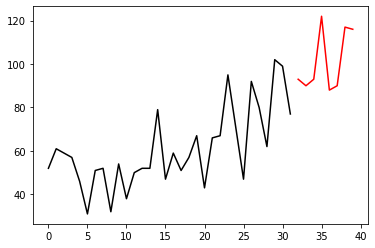

In [ ]:
forecast.plot_data(only_test=False)

<Figure size 432x288 with 0 Axes>

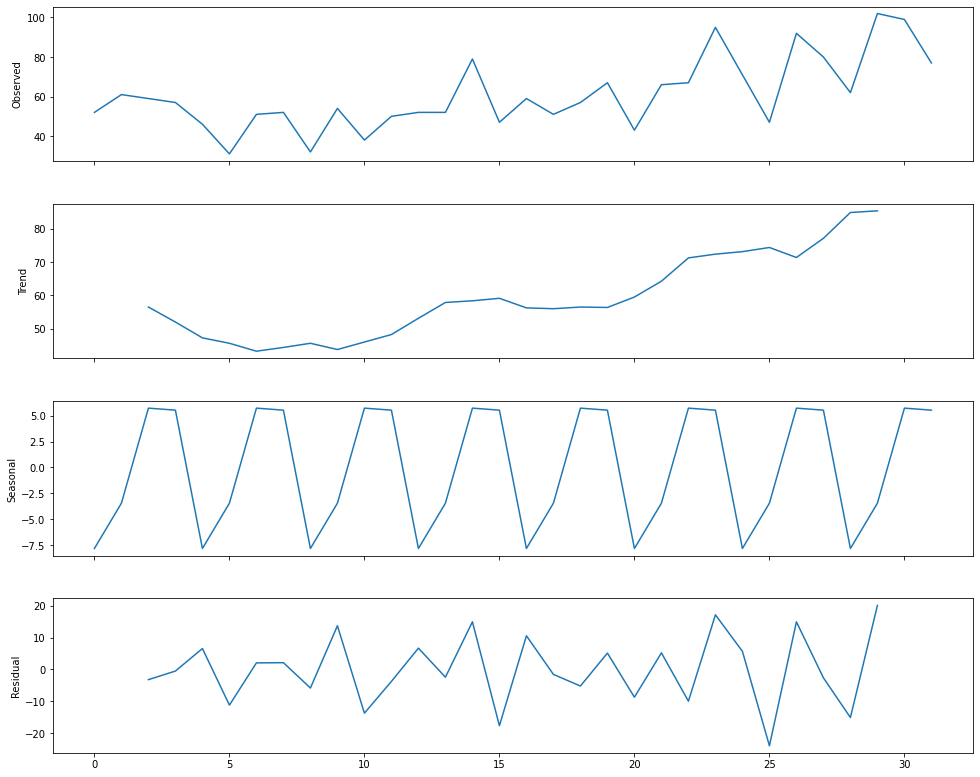

In [ ]:
forecast.show_seasonal_decompose()

There a visual trend in the data, but to be sure it is necessary to test the stationarity of the time series

**Test stationarity**

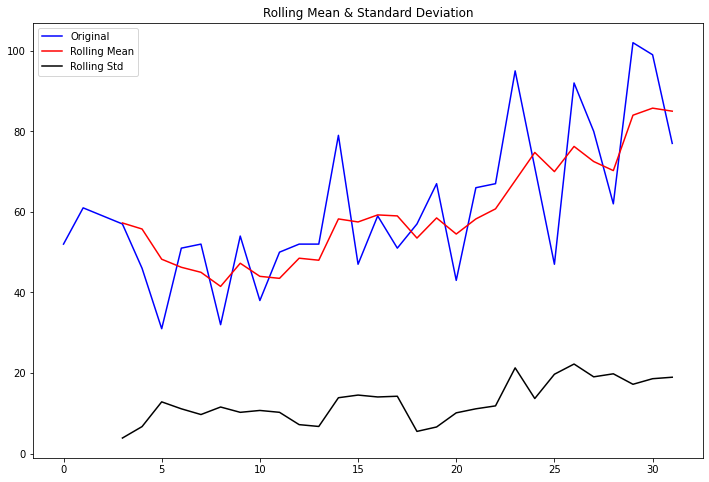

Results of Dickey-Fuller Test:
p-value = 0.9384. The series is likely non-stationary.
Test Statistic                 -0.200610
p-value                         0.938449
#Lags Used                      2.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


In [ ]:
forecast.test_stationarity()

The data is officialy non-stationary because the p_value is higher than the 5% threshold of significance. It is necessary to induce the stationarity.

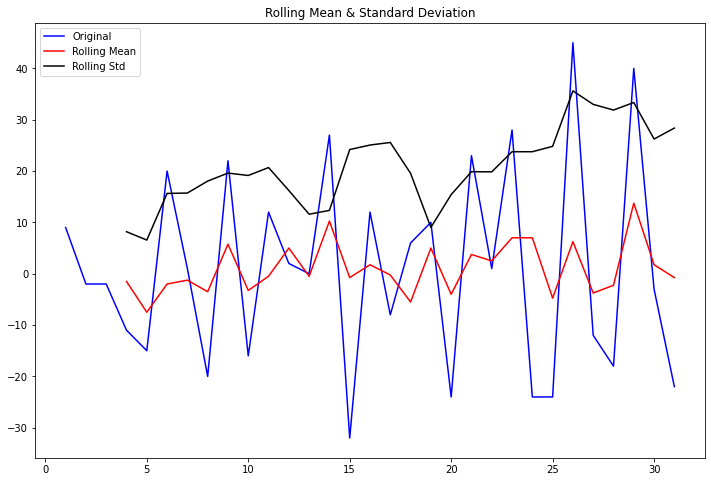

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -8.204187e+00
p-value                        7.097335e-13
#Lags Used                     1.000000e+00
Number of Observations Used    2.900000e+01
Critical Value (1%)           -3.679060e+00
Critical Value (5%)           -2.967882e+00
Critical Value (10%)          -2.623158e+00
dtype: float64


In [ ]:
forecast.make_non_stationary()

The data is now stationary

**Seasonality analysis**

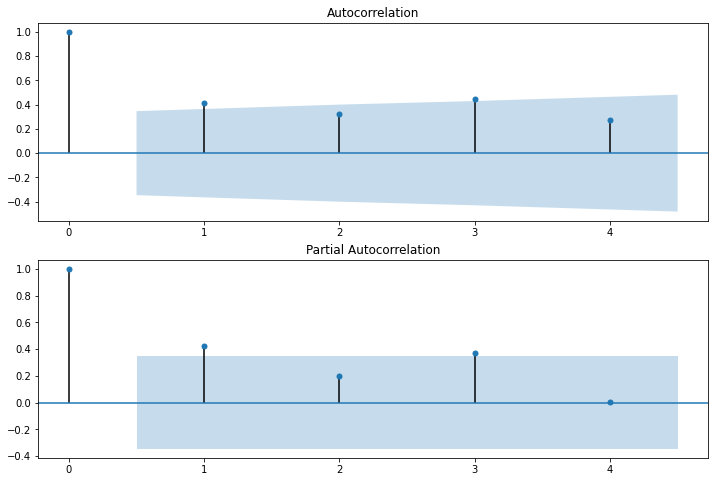

In [ ]:
forecast.seasonality_analysis()

There are two higher points in the autocorrelation plot, so it may exist some seasonality every two quarters. Therefore, a SARIMA model with order (2,2,0) will be tested.


Test MAE: 10.3
Test RMSE: 11.4




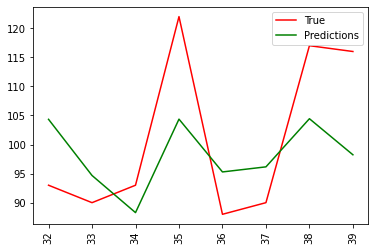

In [ ]:
pred = forecast.train_and_test_model('sarima', order=(2,2,0))

Test MSE: 14.4
Test RMSE: 19.4




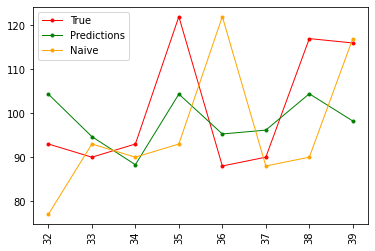

In [ ]:
forecast.compare_with_naive(pred)

The MSE of the SARIMA model is lower than the MSE of the Naive predictions and it successfully predicts the increases and decreases of the crimes.

#### Test with CATEDRAL district

In [ ]:
DISTRICT = 'CATEDRAL'

forecast = CrimeForecasting(DISTRICT, 'Quarter')

CATEDRAL

Number of days in train data = 32
Number of days in test data = 8


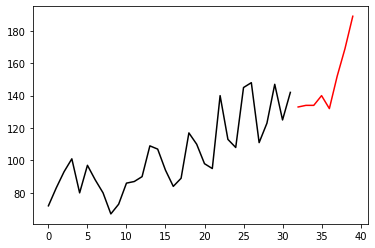

In [ ]:
forecast.plot_data(only_test=False)

<Figure size 432x288 with 0 Axes>

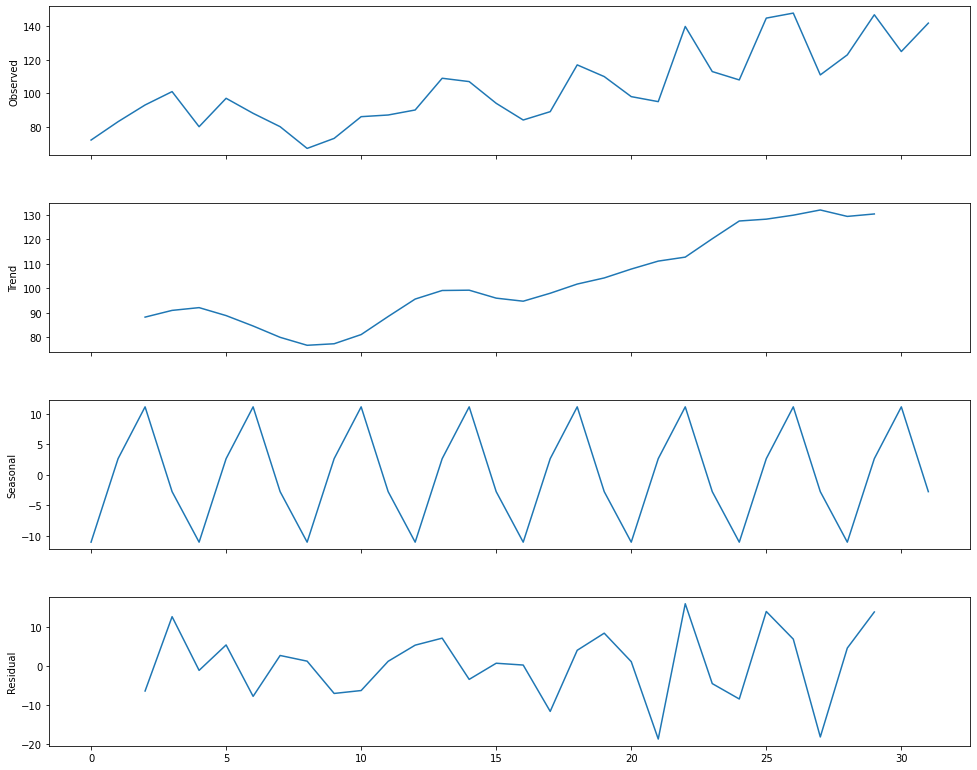

In [ ]:
forecast.show_seasonal_decompose()

There a visual trend in the data, but to be sure it is necessary to test the stationarity of the time series

**Test stationarity**

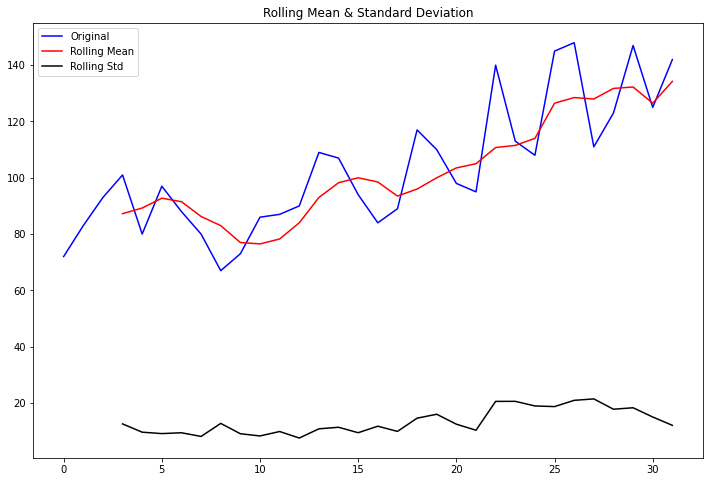

Results of Dickey-Fuller Test:
p-value = 0.9339. The series is likely non-stationary.
Test Statistic                 -0.237674
p-value                         0.933879
#Lags Used                      2.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


In [ ]:
forecast.test_stationarity()

The data is officialy non-stationary because the p_value is higher than the 5% threshold of significance. It is necessary to induce the stationarity.

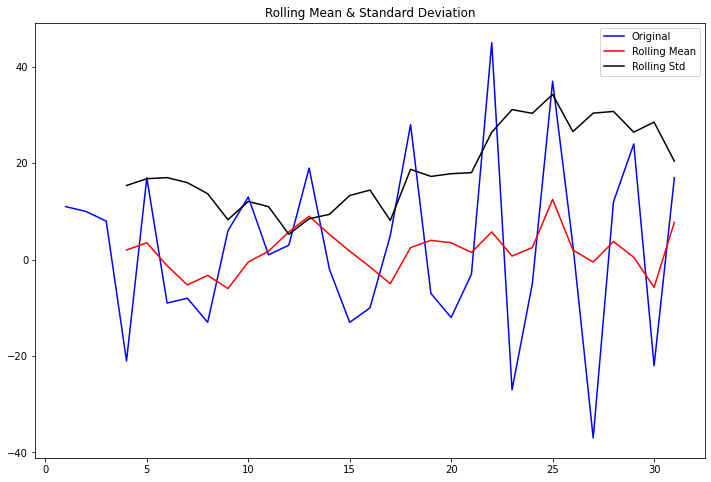

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -8.309737e+00
p-value                        3.817528e-13
#Lags Used                     1.000000e+00
Number of Observations Used    2.900000e+01
Critical Value (1%)           -3.679060e+00
Critical Value (5%)           -2.967882e+00
Critical Value (10%)          -2.623158e+00
dtype: float64


In [ ]:
forecast.make_non_stationary()

The data is now stationary

**Seasonality analysis**

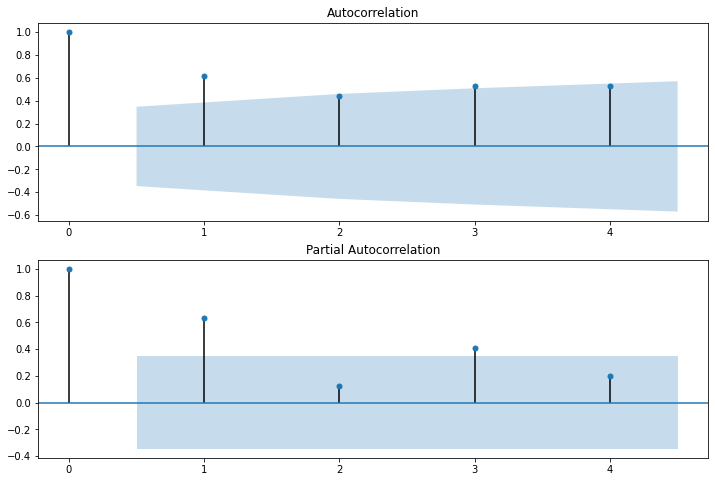

In [ ]:
forecast.seasonality_analysis()

There are two higher points in the autocorrelation plot, so it may exist some seasonality every two quarters. Therefore, a SARIMA model with order (2,2,0) will be tested.


Test MAE: 35.1
Test RMSE: 36.4




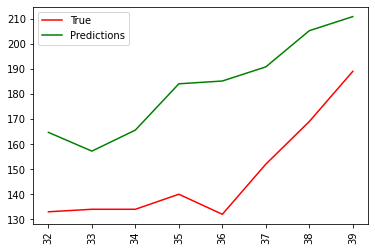

In [ ]:
pred = forecast.train_and_test_model('sarima', order=(2,2,0))

Test MSE: 10.1
Test RMSE: 12.6




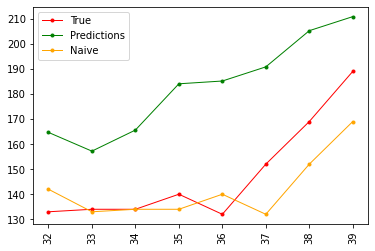

In [ ]:
forecast.compare_with_naive(pred)

Although the MSE of the SARIMA model is higher than the MSE of the Naive predictions (because of the shift in the vertical axis - over estimation), it successfully predicts the increases and decreases of the crimes, cathing the positive trend of this test set.

#### Final comments regarding forecasting

It was possible to successfully predict the future 2 years of crime by quarter, for indivual districts, for several of the 11 districts in San José. For the ones that did not obtained a good forecasting, it may be necessary to perform a analysis about their characteristics (geographics and demographics) in order to understand if there is any factor impacting the crime incidence.

The prediction of crime by quarter allows the dynamic update of the number of crimes per district normalized by population, one the features (one of the most important) used to obtain the safety score. By obtaining the feature value for a future quarter, it is possible to then recalculate the safety score and that was obtain an estimation of the safety score grid for that future quarter. This allows the security forces to monitor the evolution of crime but also the evolution of the safety feeling in the streets. Consequently, it will allow an informed management of the distribution of forces across the city for the near future (in order to move more resources to areas with an expected crime increase or safety score decrease).

### 7. ***Route Optimization for SafeMaps***<a name="optimization"></a>
[(back to top)](#top)

#### Context

After scoring each zone in terms of sexual harassment danger, SafeMaps will find different safety level paths from zone A to zone B, that the user can choose from, optimized towards:
1. Minimizing overall travelled distance (independently of danger scores),
2. Minimizing overall danger score (independently of distance),
3. Minimizing travelled distance, restricted by a danger score threshold (i.e. preventing the path from going through zones with scores above a certain level)

*Notes:*
* *It's important to add threshold-based paths to the product, as overall score minimization might include high danger zones (that are balanced by very low danger zones)*
* *This can pose an obvious problem for women as it can become irrelevant to have a generally very safe path if it goes through at least one very unsafe zone*
* *To help the user make the best decision every path will be associated with the total danger score, the maximum danger score per zone and the distance travelled*

#### Algorithm

**Dijkstra's Shortest Path**:

With zone-based paths and having to minimize distances as well as danger scores, one of the best tools to use is the Dijkstra's "shortest path" algorithm. It is a graph-based tool, where nodes will represent zones and the leg costs (weights) will be the distances betweeen adjacent zones or the danger score of the destination zone.

Why Dijkstra?
* Has very little restrictions, which means it always works and finds the lowest cost path, as long as the costs are always positive (as it happens with distances and scores) and if the problem is set as a minimization problem
* Easy to apply and computes paths very quickly (if the graphs are already created)

**Graph Creation**:

The trickiest part is to create the graphs correctly, and the basic rationale behind the algorithm was to create a cost matrix (for each type of cost: "distance" and "danger score") that would have the costs between adjacent zones (zones that touch, either by the sides or the vertices):
* Distance: calculated between zone centroids
* Score: the score from zone A to B is equal to the score of zone B (and vice-versa), to make sure there was no need to create negative costs on the graphs
* This matrixes take some time to compute but only need to be calculted when the zones danger scores are updated, and therefore can be saved and loaded quickly, allowing a very fast computation for regular use.

Afterwards, to create the graphs, the matrixes are iterated and the graphs are constructed with the information saved.

For the threshold based paths, the user can define the danger thresholds or they are set automatically (with empirical
values), and the algorithm will simply remove the "no-passage" zones from the distance matrix and calculate the graphs from there. Sometimes, the thresholds can be such that it is impossible to move from zone A to B without going through a "no-passage" zone, thus preventing that path from being calculated.

**Code**:

A Router class was built, allowing any router object to be created with a dataframe that contains zone ID, its geometry and danger score (the user has the option to define the danger thresholds on creation).
The object can build the model from scratch and create the cost matrixes, or load them. It will also try to find 5 types of paths (the shortest, the overall safest and 3 thresholds paths: low, medium and high danger) and plot them.

In [ ]:
class Router(object):
    def __init__(self, data, danger_thresholds = {'Low': None, 'Medium': None, 'High': None}):

        # city zone dataframe (ID, geometry, danger score)
        self.data = data 
        self.data['safety_score'] = self.data.danger_score.apply(lambda x: self.data.danger_score.max() - x)  # inverse scores for min cost algorithm
        
                        # dijkstra node network graph for shortest path algorithm
        self.graphs = {'distance': dj.Graph(), 
                        # dijkstra node network graph for safest path algorithm
                       'danger': dj.Graph(), 
                        # dijkstra node network graph for danger threshold paths algorithms
                       'high_danger': dj.Graph(),
                       'medium_danger': dj.Graph(),
                       'low_danger': dj.Graph()}
        
                              # zone matrix with distances between adjacent zones (rest filled with NaN)
        self.cost_matrixes = {'distance' : pd.DataFrame(), 
                              # zone matrix with danger scores between adjacent zones (score from zone A to zone B equals score of B, rest filled with NaN)
                              'danger' : pd.DataFrame(), 
                              # zone matrixes with danger scores between adjacent zones, except threshold danger zones (score from zone A to zone B equals score of B, rest filled with NaN)
                              'high_danger' : pd.DataFrame(), 
                              'medium_danger' : pd.DataFrame(),
                              'low_danger' : pd.DataFrame()}
        
        self.danger_thresholds = danger_thresholds  # safety score thresholds for path finder
        
        self.paths = {}
        self.path_types = ['shortest','high_danger','medium_danger', 'low_danger', 'safest']
        for path in self.path_types:
            self.paths[path] = {'path': [], 'danger_score': 0, 'dist': 0}
        
        self.create_centroids()

    def create_centroids(self):
        ########
        # Adds centroids from geometry to original dataframe
        #######
        self.data['centroids'] =  self.data['geometry'].centroid

    def plot_centroid(self):
        ########
        # Plots centroids for confirmation purposes
        #######
        fig, ax = plt.subplots(figsize=(40, 30))
        ax.set_aspect('equal')
        self.data.geometry.plot(ax=ax, color='white', edgecolor='black')
        self.data.centroid.plot(ax=ax, color='red', markersize = 1)

        return self.data['centroids']
    
    def create_matrixes(self):
        #######
        # Creates main cost matrixes for adjacent zones (cost = distance and danger score)
        #######
        
        dist_matrix = pd.DataFrame(self.data.ID)
        danger_matrix = pd.DataFrame(self.data.ID)
        
        counter = 0
        total = len(dist_matrix)
        start = time()
        
        print('Creating Distance and Danger Matrixes ....')
        for row in self.data.itertuples():
            zone = row.ID
            
            # Find zone neighbours
            neighbours = self.data[self.data.touches(row.geometry)]
            
            # Merge danger scores of neigbours with danger matrix (non-neigbours filled with NaN)
            temp_danger = neighbours[['ID', 'danger_score']].rename(columns={'danger_score':zone})
            danger_matrix = danger_matrix.merge(temp_danger, on='ID', how='left')
            
            # Calculate distance from zone to neighbours (using centroids) and merge with dist_matrix (column with distances named as the zone)
            temp_distance = gpd.GeoDataFrame(neighbours.geometry.distance(row.centroids)).reset_index().rename(columns={'index' : 'ID', 0:zone})
            dist_matrix = dist_matrix.merge(temp_distance, on='ID', how='left')

            end = time()
            current = round((end-start)/60, 2)
            counter += 1
            print (f' {counter} of {total} | {current} of estimated {round(current/counter * total, 2)} min ...', end='\r')

        # Update class properties
        self.cost_matrixes['distance'] = dist_matrix.copy()
        self.cost_matrixes['danger'] = danger_matrix.copy()
        
        print('')
        return dist_matrix, danger_matrix
    
    def create_threshold_matrixes(self):
        #######
        # Creates threshold cost matrixes for adjacent zones (cost = distance)
        #######
        
        # Check if distance matrix is built
        if self.cost_matrixes['distance'].empty:
            raise ValueError("Distance Matrix is empty. Create Matrixes first!")
        
        print('Creating Threshold Matrixes ....', end='\r')
        
        # Check if thresholds are set (if not create with percentiles)
        if not all(thresh for thresh in self.danger_thresholds.values()):
            self.danger_thresholds['Low'] = np.percentile(self.data.danger_score, 65)
            self.danger_thresholds['Medium'] = np.percentile(self.data.danger_score, 75)
            self.danger_thresholds['High'] = np.percentile(self.data.danger_score, 85)
            
        # Create threshold matrixes from distance cost matrix
        for danger_level, threshold in zip(['high_danger', 'medium_danger', 'low_danger'], ['High', 'Medium', 'Low']):
            aux = self.data[self.data.danger_score < self.danger_thresholds[threshold]]
            self.cost_matrixes[danger_level] = self.cost_matrixes['distance'][self.cost_matrixes['distance'].ID.isin(aux.ID)]
        
        print('Threshold Matrixes created successfully!')
        
    def create_graphs(self):
        #######
        # Creates Dijkstra's graphs from cost matrixes
        #######
        
        # Check if matrixs are set
        if any(matrix.empty for matrix in self.cost_matrixes.values()):
            raise ValueError("Cost Matrixes are empty. Create Matrixes first!")
 
        print('Creating graphs ....', end='\r')
        
        # Create aux dfs for each matrix/ graph
        aux = {}
        for key in self.cost_matrixes.keys():
            aux[key] = self.cost_matrixes[key].copy()
        
        # Get nodes/zones from any cost matrix
        nodes = aux['distance'].drop(columns=['ID'])
        nodes = nodes.columns.to_list()
        
        # Iterate over nodes, type of cost_matrixes and the matrix itself (while dropping non-neighbours)
        counter = 0
        total = len(nodes) * len(aux)
        # For each zone
        for zone in nodes:
            # For each type of graph (distance, safety or thresholds)
            for key in aux.keys():
                # Drop non-neighbours of current zone
                temp = pd.DataFrame(aux[key][zone].dropna())
                # For each neighbour add leg between current zone and neighbour  
                for neighbour, cost in temp.itertuples():
                    self.graphs[key].add_edge(int(zone), int(neighbour), cost)
                counter += 1
                print(f'Created {counter} of {total} nodes',end='\r')
        
        print('Graphs created successfully!')
        
    def find_path(self, start_zone, end_zone, prints=True):
        #######
        # Finds best paths according to Dijkstra's algorithm for each type of path
        #######
        if prints:
            print('Finding paths ....', end='\r')
        
        # Reset path information
        for path in self.path_types:
            self.paths[path] = {'path': [], 'danger_score': 0, 'dist': 0}
        
        # Shortest path
        counter = 1
        try:
            self.paths['shortest']['path'] = dj.find_path(self.graphs['distance'], start_zone, end_zone).nodes
        except:
            if prints:
                print(f'Unable to find Shortest Path between zones {start_zone} and {end_zone}')
            else:
                pass
        # Safest path
        try:
            self.paths['safest']['path'] = dj.find_path(self.graphs['danger'], start_zone, end_zone).nodes
            counter += 1
        except:
            if prints:
                print(f'Unable to find Safest Path between zones {start_zone} and {end_zone}')
            else:
                pass
            
        # High Danger, Medium Danger, and Low Danger paths
        for danger_level in ['high_danger', 'medium_danger', 'low_danger']:
            try:
                self.paths[danger_level]['path'] = dj.find_path(self.graphs[danger_level], start_zone, end_zone).nodes
                counter += 1
            except:
              if prints:
                  print(f'Unable to find {danger_level} path between zones {start_zone} and {end_zone}')         
              else:
                  pass
            
        # Calculate distances, average and maximum danger scores for each path
        for path in self.path_types:
            total_score = self.data[self.data.ID.isin(self.paths[path]['path'])].danger_score.sum()
            self.paths[path]['danger_score'] = round(total_score/len(self.paths[path]['path'])) if total_score > 0 else 0
            self.paths[path]['dist'] = self.path_dist_calculator(self.paths[path]['path'])
            self.paths[path]['max_danger'] = round(self.data[self.data.ID.isin(self.paths[path]['path'])].danger_score.max()) if total_score > 0 else 0
        if prints:
            print(f'{counter} of {len(self.paths)} paths calculated successfully!')
        return self.paths
    
    def path_dist_calculator(self, path):
        #######
        # Support method to calculate total distance in path
        #######
        
        dist = 0
        i = 0
        # While in path
        while i < len(path) - 1:
            # Current zone
            zone_1 = path[i]
            # Next zone
            zone_2= path[i+1]
            # Get current zone's neighbours only
            temp = pd.DataFrame(route.cost_matrixes['distance'][['ID',str(zone_1)]].dropna())
            # Find next zone in neighbouts and add distance to dist
            temp = temp[temp.ID == zone_2]
            dist += temp.at[zone_2, str(zone_1)]
            i += 1
        
        # Approximate distance to meters (rough estimate)
        dist = round(dist * 100000) 
        return dist
            
    def plot(self):
        #######
        # Plots all calculated paths
        #######
        
        # Reset route type in dataframe
        try:
            self.data.drop(inplace=True, columns={'route_type'})
        except:
            pass
        
        # Create route type in dataframe to label plot
        counter = 1
        for route_type in self.paths.keys():
            self.data.loc[self.data.ID.isin(self.paths[route_type]['path']), 'route_type'] = f"{counter} | {route_type} | Avg Danger: {self.paths[route_type]['danger_score']} | Dist: {self.paths[route_type]['dist']}m | Max Danger: {self.paths[route_type]['max_danger']}"
            counter += 1
        
        # Plot
        fig, ax = plt.subplots(figsize=(40, 30))
        self.data.plot(ax=ax, color='white', edgecolor='black')
        self.data.plot(column='route_type', ax=ax, legend=True, legend_kwds={'fontsize':30})
        ax.set_axis_off()

    def save(self):
        #######
        # Saves main cost matrixes (distance and danger) as .csv
        #######
        
        files = ['distance', 'danger']
        counter = 1
        total = len(files)
        for file in files:
            print(f'Saving file {counter} of {total}',end='\r')
            #self.graphs[file].dump(f'graph_{file}.pickle')
            self.cost_matrixes[file].to_csv(f'DATA/support/matrix_{file}.csv')
            counter += 1
        print('Saved files successfully!')
        
    def load(self):
        #######
        # Loads main cost matrixes (distance and danger) from .csv
        #######
        
        try:
            files = ['distance', 'danger']
            counter = 1
            total = len(files)
            for file in files:
                print(f'Loading file {counter} of {total}',end='\r')
                #self.graphs[file] = dj.Graph.load(f'graph_{file}.pickle')
                self.cost_matrixes[file] = pd.read_csv(f'DATA/support/matrix_{file}.csv')
                self.cost_matrixes[file].drop(inplace=True, columns=['Unnamed: 0'])
                counter += 1
            print('Loaded files successfully!')
            
            # Build rest of object
            self.create_threshold_matrixes()
            self.create_graphs()
        
        except:
            print('Unable to load files! Confirm file existance.')
    
    def build(self):
        #######
        # Builds object from scratch without loading information
        #######
        
        self.create_matrixes()
        self.create_threshold_matrixes()
        self.create_graphs()
        self.save()


### 8. ***SafeMaps in action***<a name="safemaps"></a>
[(back to top)](#top)

In [ ]:
optimization_grid = grid[['geometry', 'danger_score']]

scaler = MinMaxScaler(feature_range=(0, 100))
optimization_grid['danger_score'] = scaler.fit_transform(np.array(optimization_grid['danger_score']).reshape(-1, 1))

optimization_grid['ID'] = optimization_grid.index
optimization_grid['centroids'] = optimization_grid['geometry'].centroid

In [ ]:
route = Router(optimization_grid)
route.data

,geometry,danger_score,ID,centroids,safety_score
0,"POLYGON ((-84.18000 9.96800, -84.17933 9.96800...",99.113174,0,POINT (-84.17967 9.96833),0.886826
1,"POLYGON ((-84.18000 9.96867, -84.17933 9.96867...",99.547531,1,POINT (-84.17967 9.96900),0.452469
2,"POLYGON ((-84.18000 9.96933, -84.17933 9.96933...",100.000000,2,POINT (-84.17967 9.96967),0.000000
3,"POLYGON ((-84.17933 9.96800, -84.17867 9.96800...",98.100012,3,POINT (-84.17900 9.96833),1.899988
4,"POLYGON ((-84.17933 9.96867, -84.17867 9.96867...",92.411832,4,POINT (-84.17900 9.96900),7.588168
...,...,...,...,...,...
7250,"POLYGON ((-84.04800 9.92333, -84.04733 9.92333...",26.932019,7250,POINT (-84.04767 9.92367),73.067981
7251,"POLYGON ((-84.04800 9.92400, -84.04733 9.92400...",27.811549,7251,POINT (-84.04767 9.92433),72.188451
7252,"POLYGON ((-84.04800 9.92467, -84.04733 9.92467...",40.130599,7252,POINT (-84.04767 9.92500),59.869401
7253,"POLYGON ((-84.04733 9.92400, -84.04667 9.92400...",28.795159,7253,POINT (-84.04700 9.92433),71.204841


In [ ]:
# Uncomment to build model from scratch...
# route.build()

In [ ]:
# ...otherwise, load support files
route.load()

Loaded files successfully!
Threshold Matrixes created successfully!
Graphs created successfully!


Unable to find low_danger path between zones 345 and 4657
4 of 5 paths calculated successfully!


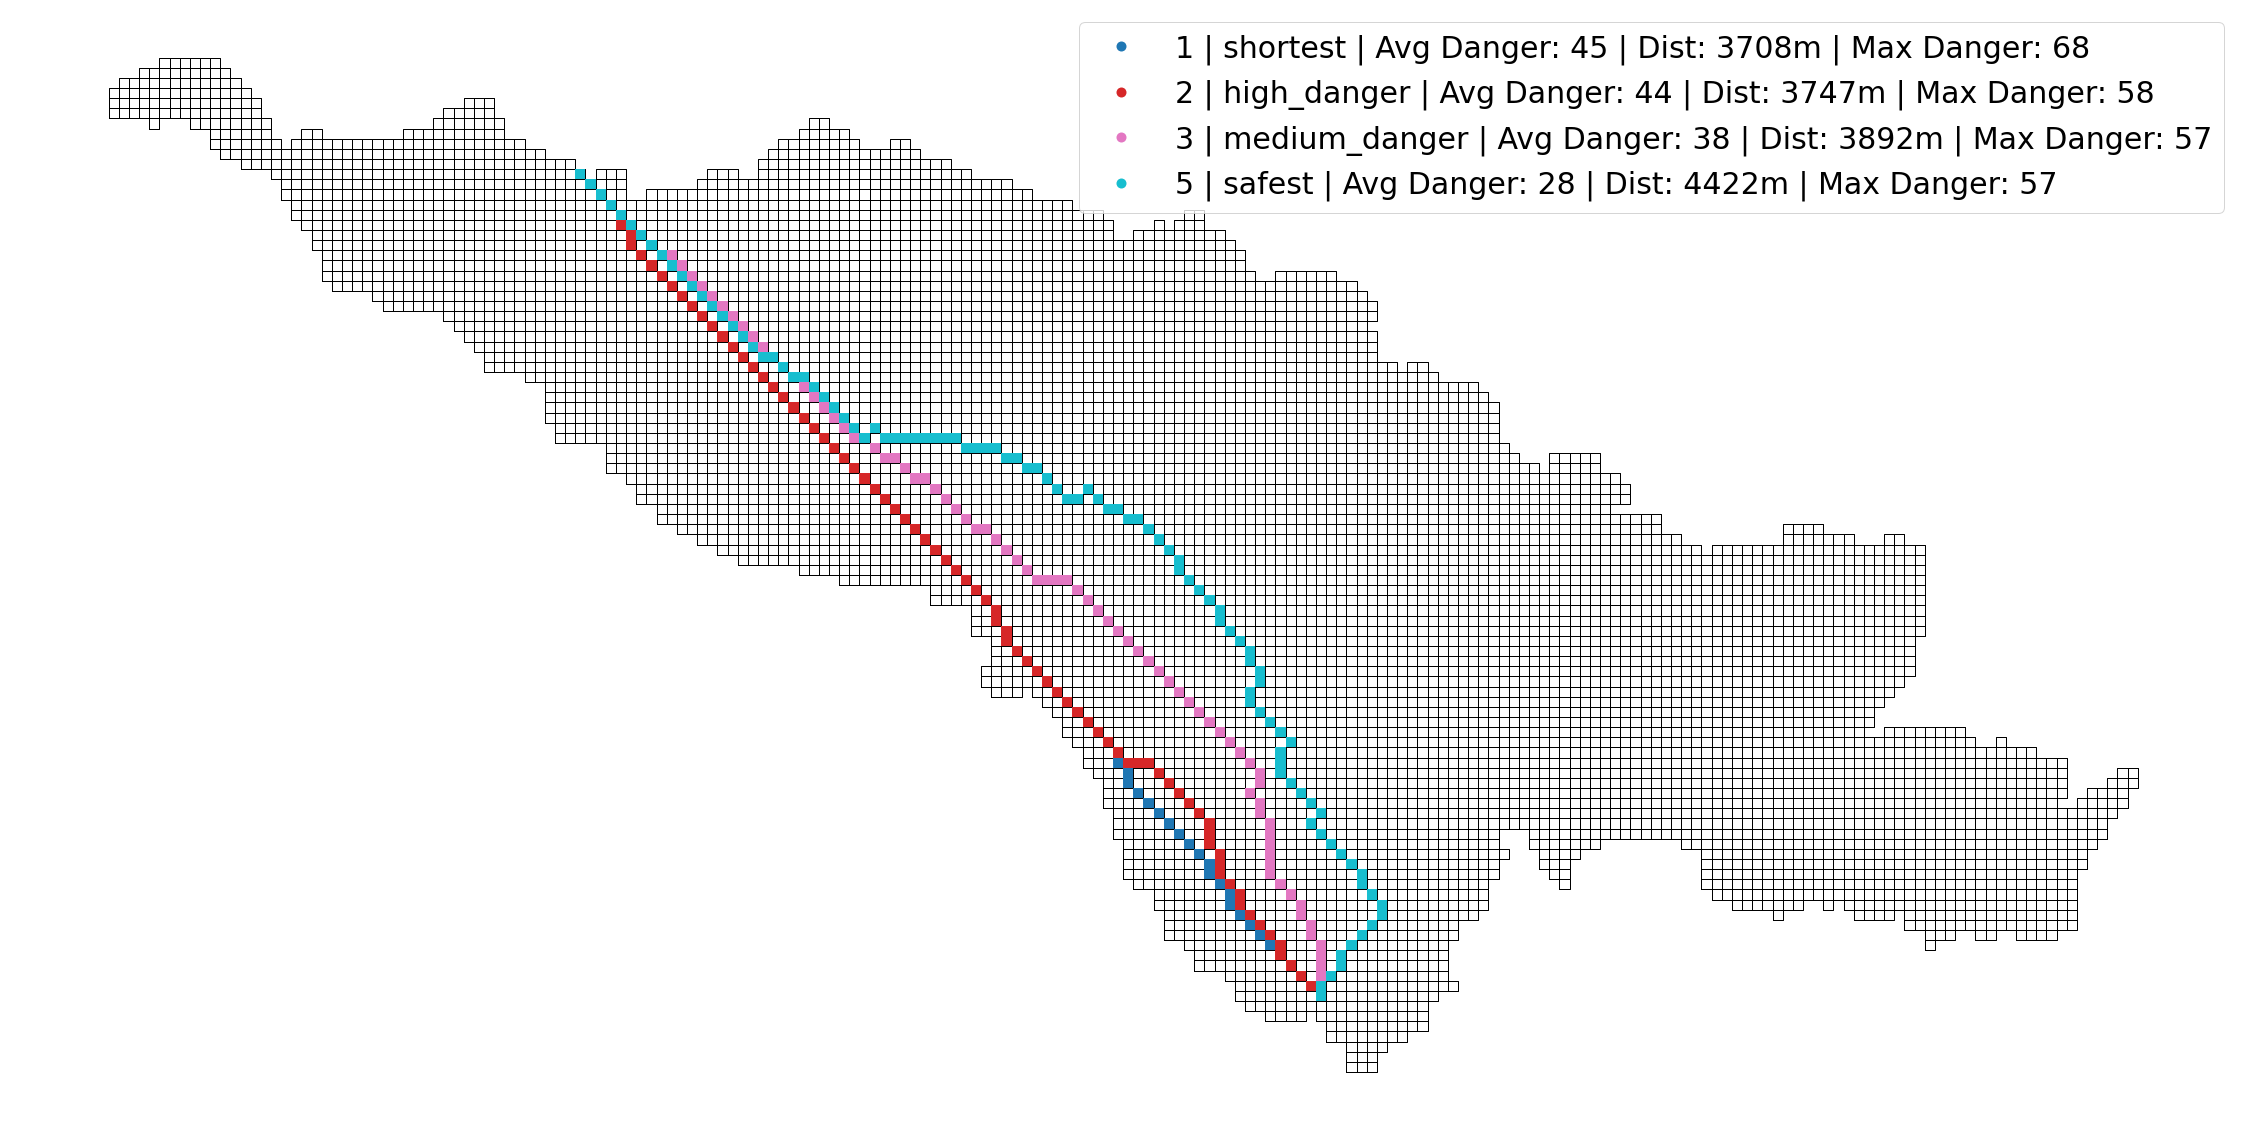

In [ ]:
route.find_path(345, 4657)
route.plot()

5 of 5 paths calculated successfully!


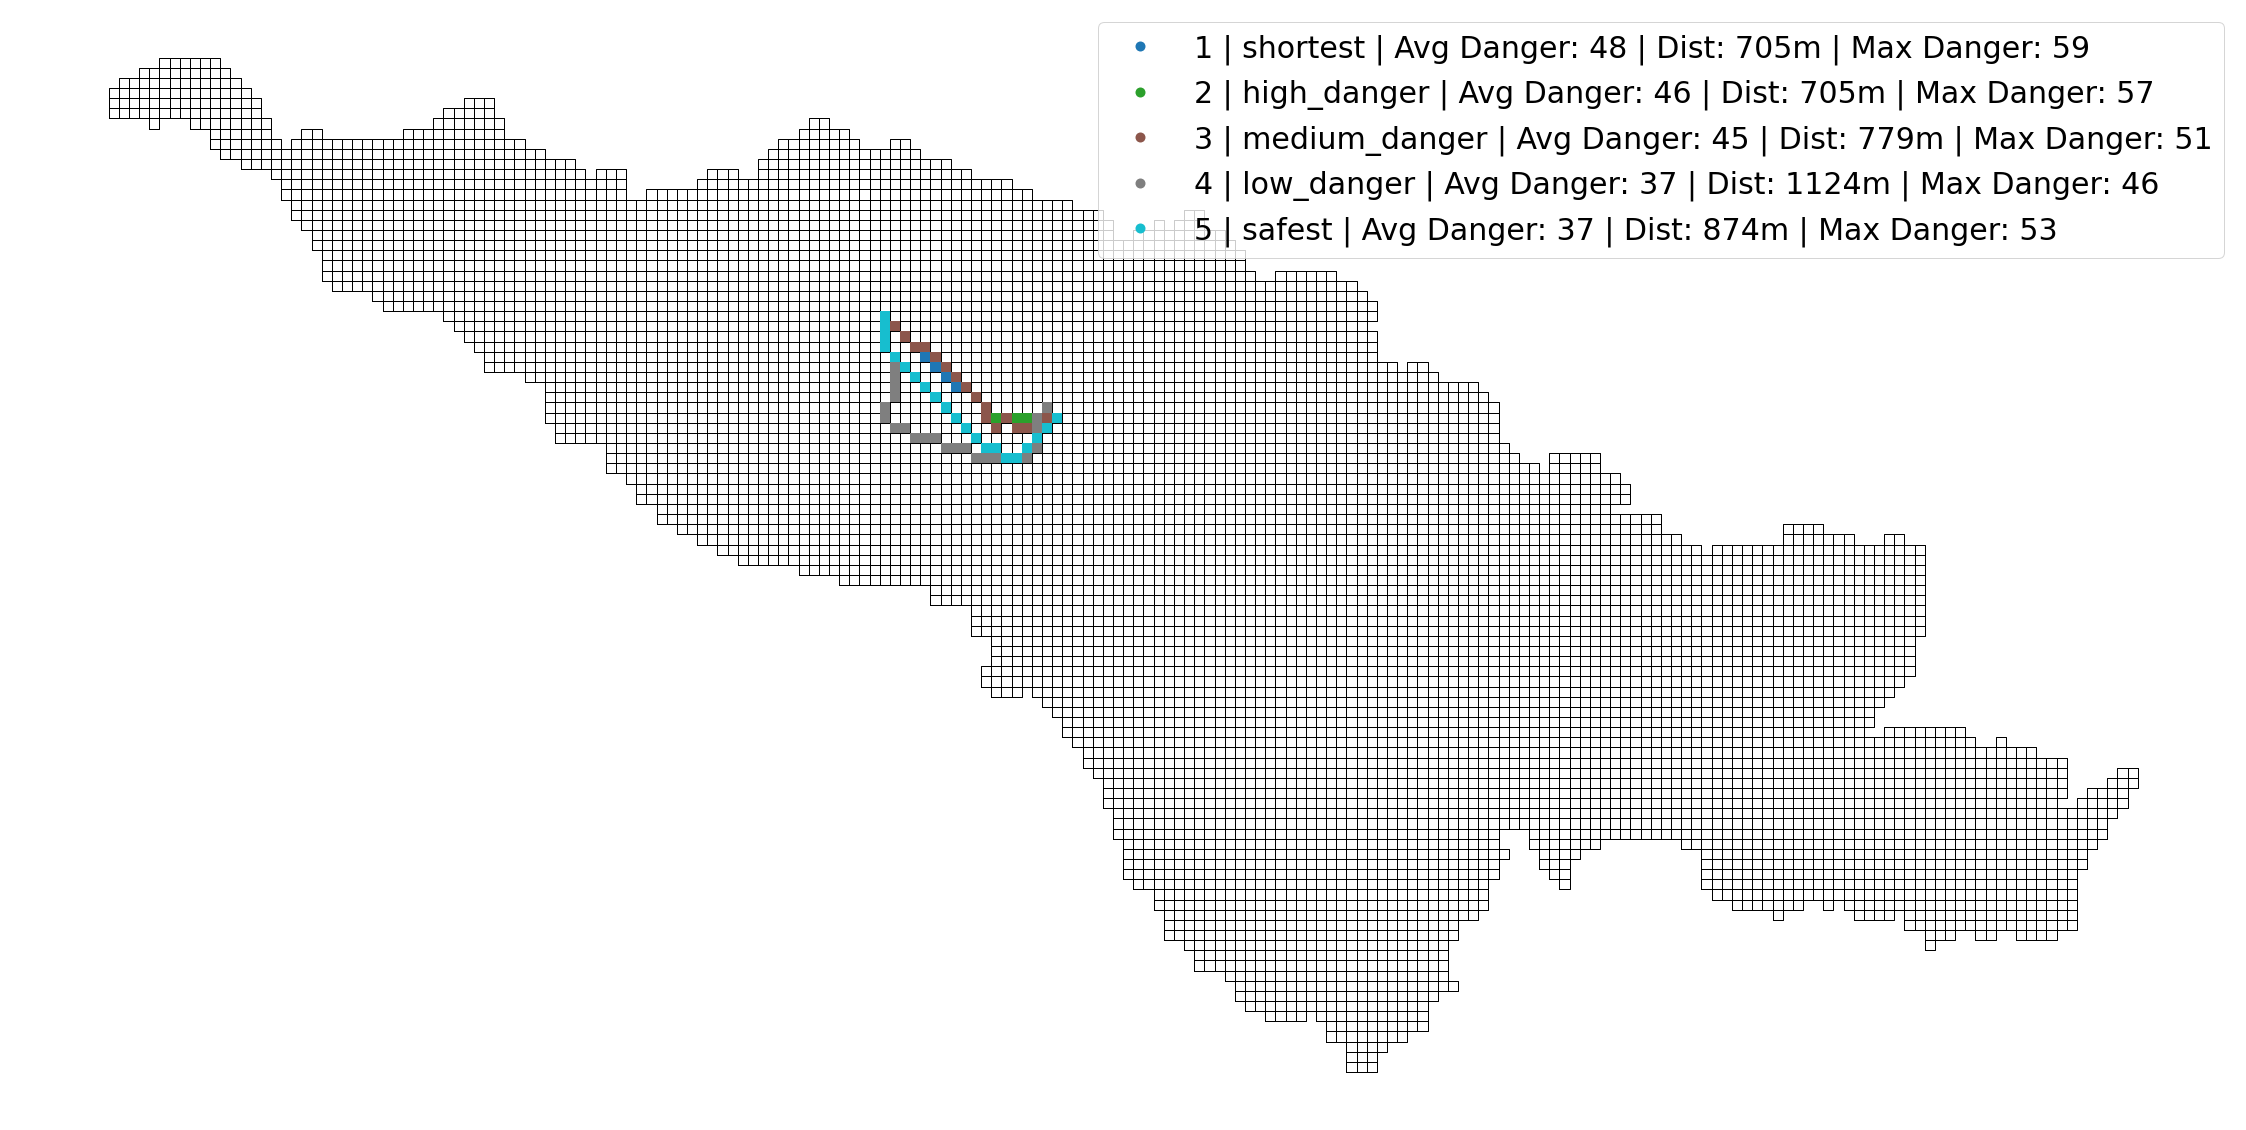

In [ ]:
route.find_path(873, 2974)
route.plot()

5 of 5 paths calculated successfully!


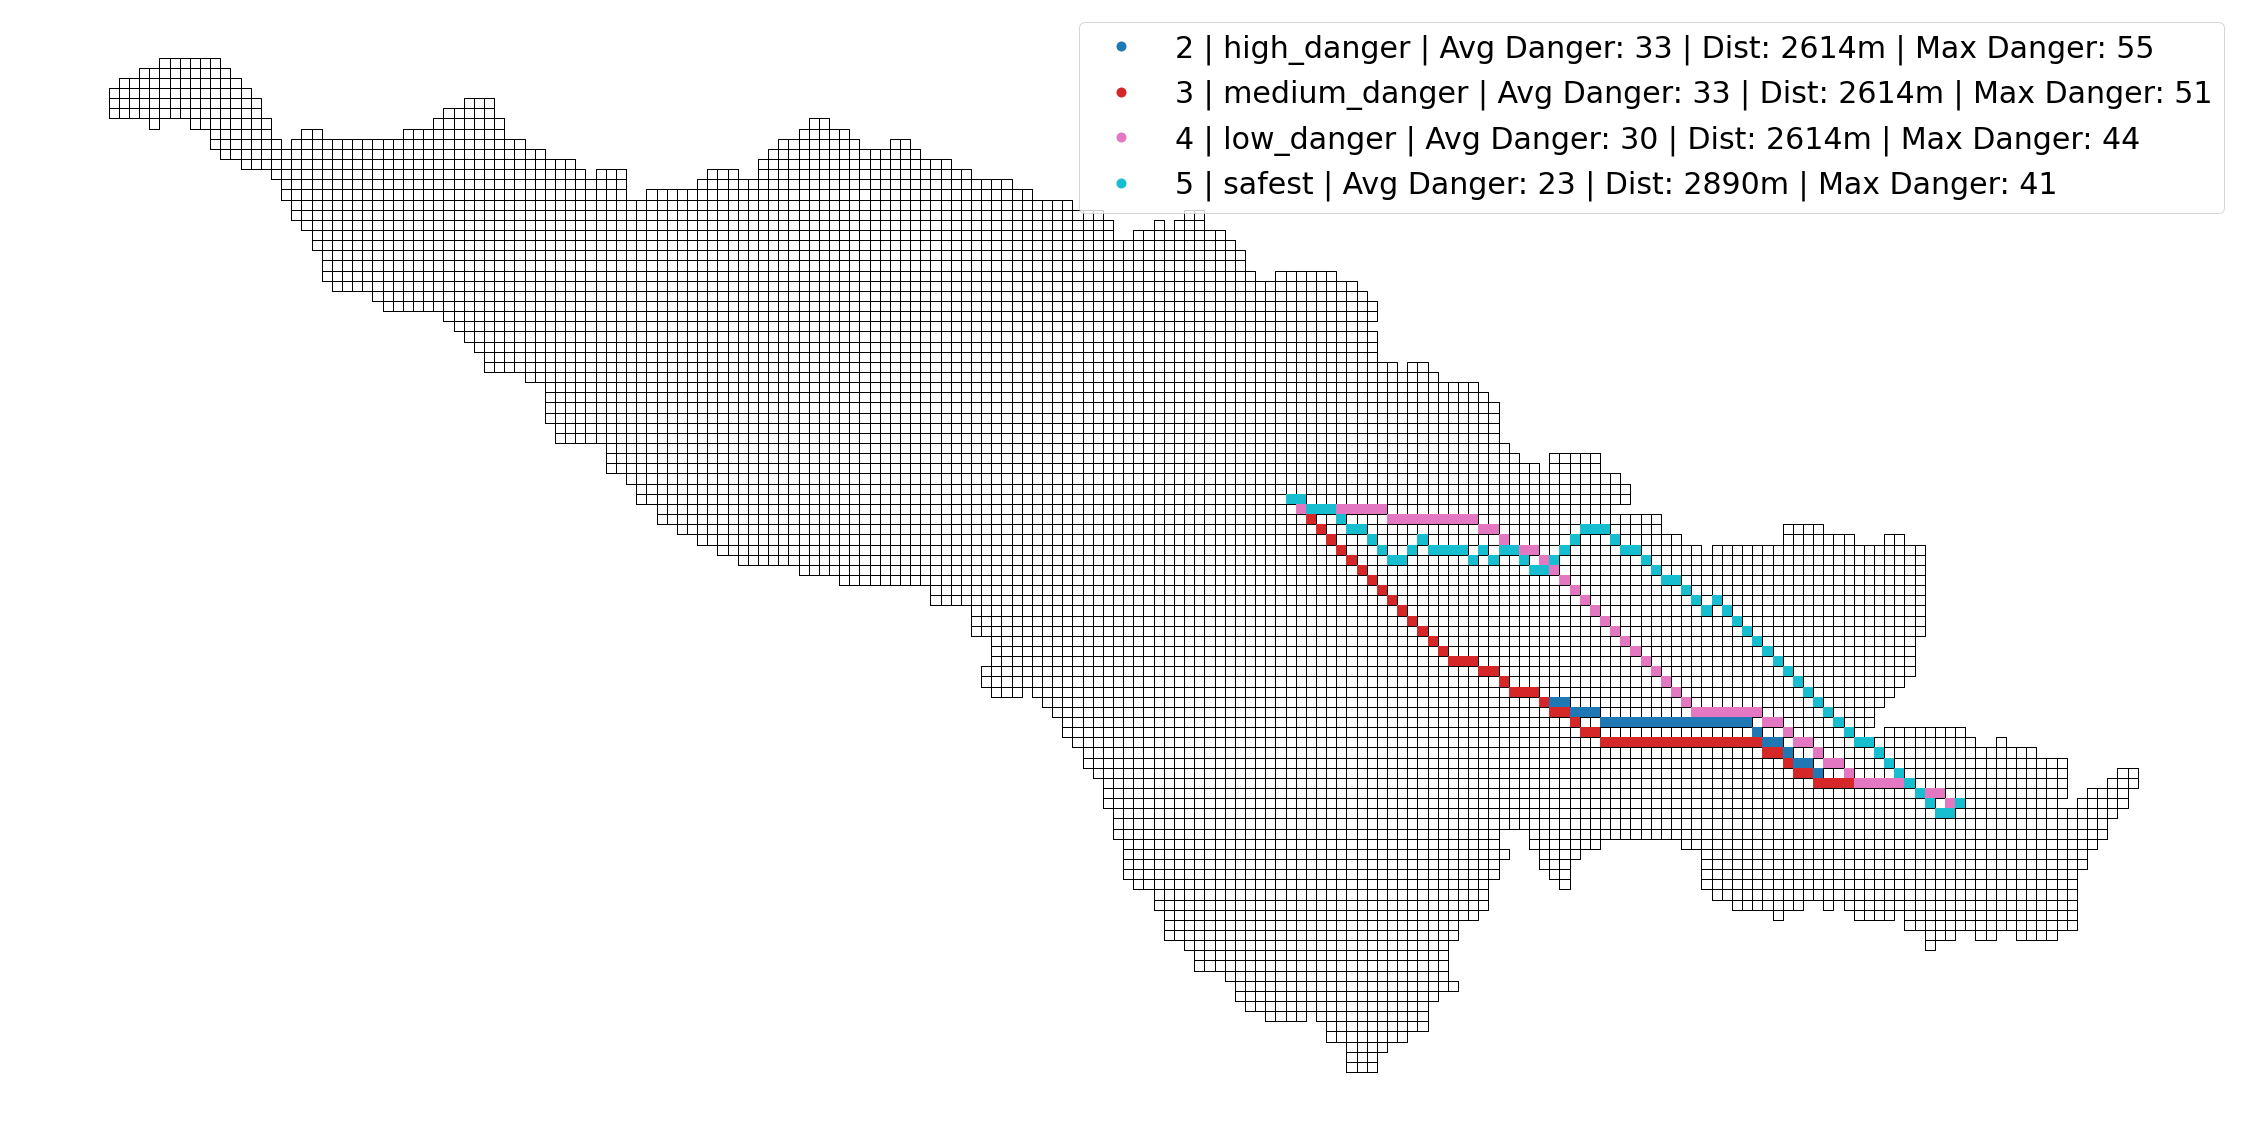

In [ ]:
route.find_path(7023, 4038)
route.plot()

*Note: the shortest path is overlapped with the high_danger path, thus not showing up in the legend (non-impactful as high danger path is safer than shortest and has the same distance, so the shortest is useless).*

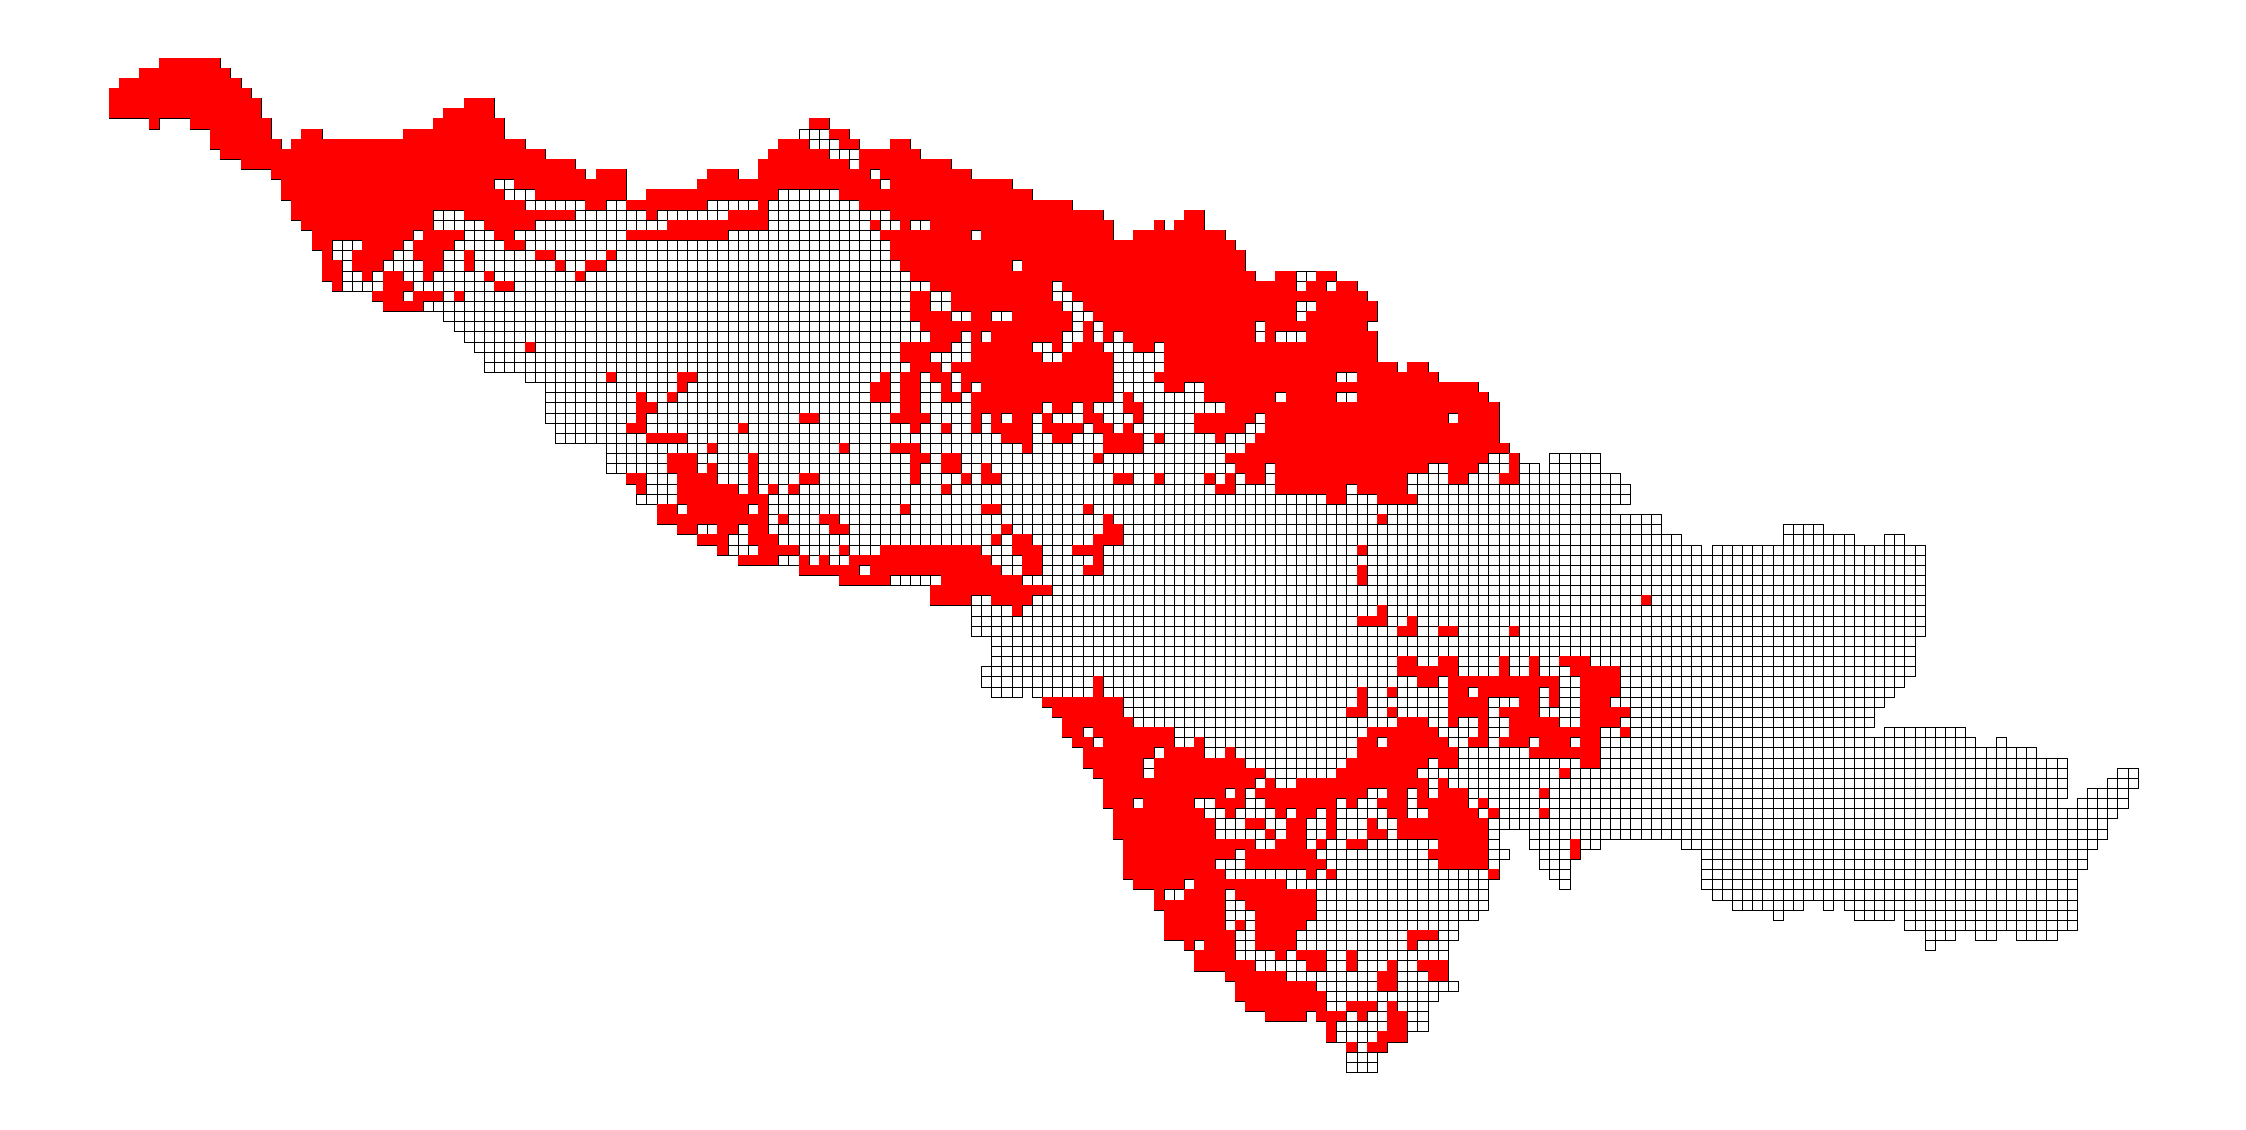

In [ ]:
# Plotting non-passage zones with low thresholds
fig, ax = plt.subplots(figsize=(40,30))
route.data.plot(ax=ax, color='white', edgecolor='black')
route.data[route.data.danger_score >= route.danger_thresholds['Low']].geometry.plot(ax=ax, color='red')
ax.set_axis_off()

#### Comments & Future Improvements

**Path Analysis**:
* Overall, as expected, as the danger score of the path decreases, the distance travelled increases. Exceptions occur between medium danger paths and the safest path due to the minimization problem (the medium path prevents the path from crossing medium or higher danger zones completely while the safest path doesn't, it just minimizes total and average score)
* Low danger paths are rarely built as many zones become uncrossable, as seen above
* The shortest path is not a straight line between zone A and B, because distance is calculated between zone centroids and a straight line might cross more zones than the zones the Dijkstra's algorithm finds. This mimics real-life conditions as the real paths are very rarely straight.

**Danger Score Minimization**:
To prevent the safest path from going through high danger zones whithout having to empirically define danger thresholds (which, as seen, can prevent the path from being built), a better solution would be to define a minimization problem that would weigh in both total danger score *and* danger score variation between zones. 
This way, the algorithm would find a path where zone scores would be all similar and, at the same time, low.

**Zone to Map transformation**:
This base algorithm and route creation can still be applied in an actual map, where the streets would be overlayed with these zones. After finding the safest zones for the path, we could find the streets that pass through those zones. If more granular results are required we could increase the number of zones in the grid.

### 9. Impact Estimation<a name="impact"></a>
[(back to top)](#top)

The impact of SafeMaps in the population safety will be estimated by taking into account multiple factors:
1. The usage of SafeMaps in the first year (market penetration);
2. The average change in danger scores between different safety paths;
3. The choices of users between safest, shortest or any threshold route.

#### ***1. Market Penetration***
To estimate market penetration there are 2 main things to consider: reach (the % of people that know about the app) and conversion (the % of people who know about the app that choose to use it):
* ***Reach***: According to Washington Post $[3]$, Waze is extremely popular in Costa Rica and in 2014 there were 300 000 active users in San José (which is an incredible number for a city that had, in 2015, 339 581 citizens, meaning 88.3% of population). This number will be used as a proxy for the reach.
* ***Conversion***: According to our survey, over 91% of people would choose to use SafeMaps.

In [ ]:
reach = 300000/339581 * 100
conversion = 0.9155844156 * 100
penetration = reach * conversion / 100
penetration

80.88654096666187

#### ***2. Average improvement in danger scores***
The most accurate estimation of improvements of danger scores would depend on knowing the flows of people between zones in San Jose. Because we don't have and couldn't find this information, we'll take the average changes in scores (and distance travelled) between different paths calculated by SafeMaps.

With 7255 zones (n), there is a total of n(n+1)/2 = 26+ million pairs of zones where we could calculate the paths, thus the computation of the paths and the average changes would be extremely exhausting. Therefore we'll estimate population mean through random sampling of 1000 pairs for path computation.

In [ ]:
# population size
n = len(optimization_grid)
population_size = n*(n+1)/2
population_size

26321140.0

In [ ]:
# pair sampling
sample_size = 1000
temp = pd.DataFrame()
np.random.seed(345)
temp['A'] = np.random.randint(0, n-1 , size=sample_size).astype(str)
temp['B'] = np.random.randint(0, n-1 , size=sample_size).astype(str)

# check if pairs have the same zone
counter = 0
for row in temp.itertuples():
    if row.A == row.B:
        counter += 1
if counter > 0:
    raise ValueError('Same zone pairs!')
    
# check if duplicate pairs
temp['AB'] = temp[["A", "B"]].apply(",".join, axis=1)
temp['BA'] = temp[["B", "A"]].apply(",".join, axis=1)
counter = temp['AB'].duplicated().sum()
for row in temp.itertuples():
    if row.A in row.B:
        counter += 1
if counter > 0:
    raise ValueError('Duplicated pairs!')  

if counter == 0:
    print('All set!')

All set!


In [ ]:
# find path and calculate changes compared with shortest
temp.A = temp.A.astype(int)
temp.B = temp.B.astype(int)

stats = {}
for t in route.path_types:
    stats[f'{t}_score'] = []
    stats[f'{t}_dist'] = []  

counter = 0
total = len(temp)
for row in temp.itertuples():
    path = route.find_path(row.A, row.B, prints=False)
    for t in route.path_types:
        length = len(path['shortest']['path'])
        if path[t]['dist'] > 0:
            score_change = (path[t]['danger_score']/length - path['shortest']['danger_score']/length)/ (path['shortest']['danger_score']/length)
            dist_change = (path[t]['dist'] - path['shortest']['dist'])/path['shortest']['dist']
        else:
            score_change = None
            dist_change = None
        stats[f'{t}_score'].append(score_change)
        stats[f'{t}_dist'].append(dist_change) 
    counter += 1
    print(f'{counter} of {total}', end='\r')
for t in route.path_types:
    temp[f'{t}_score'] = stats[f'{t}_score']
    temp[f'{t}_dist'] = stats[f'{t}_dist']

temp.to_csv('DATA/support/path_analysis.csv')
temp

,A,B,AB,BA,shortest_score,shortest_dist,high_danger_score,high_danger_dist,medium_danger_score,medium_danger_dist,low_danger_score,low_danger_dist,safest_score,safest_dist
0,3608,892,"3608,892","892,3608",0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.229167,0.279813
1,4048,5637,"4048,5637","5637,4048",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.307692,0.031348
2,6739,741,"6739,741","741,6739",0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.295455,0.040840
3,2255,4881,"2255,4881","4881,2255",0.0,0.0,0.000000,0.016403,-0.181818,0.055147,-0.272727,0.233597,-0.409091,0.175905
4,6793,4066,"6793,4066","4066,6793",0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.117647,0.000000,-0.264706,0.051223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1831,2140,"1831,2140","2140,1831",0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.045455,0.000000
996,3406,2427,"3406,2427","2427,3406",0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.029412,0.000000,-0.176471,0.018711
997,5201,778,"5201,778","778,5201",0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.088235,0.031294
998,5743,5961,"5743,5961","5961,5743",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.117647,0.155303


In [ ]:
# organize results
aux = temp.drop(columns= ['A', 'B', 'AB', 'BA', 'shortest_score', 'shortest_dist'])
stats_results = pd.DataFrame()
cols = list(aux.columns)
avgs = []
counts = []
for col in cols:
    avgs.append(aux[col].mean())
    counts.append(aux[col].count())
stats_results['Stat'] = cols 
stats_results['Avg'] = avgs
stats_results['Count'] = counts
stats_results.to_csv('DATA/support/stats.csv')
stats_results

,Stat,Avg,Count
0,high_danger_score,-0.019470,780
1,high_danger_dist,0.018302,780
2,medium_danger_score,-0.044309,590
3,medium_danger_dist,0.017946,590
4,low_danger_score,-0.076366,471
5,low_danger_dist,0.093239,471
6,safest_score,-0.246672,1000
7,safest_dist,0.157110,1000


In [ ]:
stats_results = pd.read_csv('DATA/support/stats.csv', index_col=0)
impacts = stats_results[stats_results.Stat.str.contains(r'(?!$)_score')]
impacts['Increase'] = None

In [ ]:
for i, row in impacts.iterrows():
    impacts.at[i, 'Increase'] = -row.Avg * 100
impacts

,Stat,Avg,Count,Increase
0,high_danger_score,-0.019470,780,1.947031
2,medium_danger_score,-0.044309,590,4.430868
4,low_danger_score,-0.076366,471,7.636586
6,safest_score,-0.246672,1000,24.667237


#### Margin of Error of Averages Estimations

We are estimating the average increase in safety of different type paths through a sample of 1000, because computing the mean with the entire population (26+ million paths) is computationally exhaustive. But how close is the sample average (for each type of path) to actual population mean?

According to the Central Limit Theorem, the sampling distribution of x̄ can be approximated by a normal probability distribution, for large enough samples. Therefore, we can use a z-score from the normal distribution to calculate our margin of error. For a confidence interval of 99.9%, the z-score is 3.29, and the margin of error can be calculated with 3.29 * std / srt(sample_size)

In [ ]:
impacts['Std'] = None
impacts['Error'] = None
impacts['Error_Perc'] = None

for i, row in impacts.iterrows():
    std = temp[row.Stat].std()
    impacts.at[i, 'Std'] = std
    error = 3.29 * std / math.sqrt(row.Count)
    impacts.at[i, 'Error'] = error
    impacts.at[i, 'Error_Perc'] = error/ row.Increase * 100
    print(f'There is a 99.9% chance that the real safety increase for the {row.Stat[:-6]} path is {round(row.Increase, 3)}% ± {round(error,3)}')

impacts

There is a 99.9% chance that the real safety increase for the high_danger path is 1.947% ± 0.006
There is a 99.9% chance that the real safety increase for the medium_danger path is 4.431% ± 0.009
There is a 99.9% chance that the real safety increase for the low_danger path is 7.637% ± 0.013
There is a 99.9% chance that the real safety increase for the safest path is 24.667% ± 0.012


,Stat,Avg,Count,Increase,Std,Error,Error_Perc
0,high_danger_score,-0.019470,780,1.947031,0.047686,0.005617,0.288513
2,medium_danger_score,-0.044309,590,4.430868,0.065729,0.008903,0.200926
4,low_danger_score,-0.076366,471,7.636586,0.085063,0.012895,0.16886
6,safest_score,-0.246672,1000,24.667237,0.112094,0.011662,0.047278


With a sample size as big as 1000, we get very low margins of error (around 0.5%) with high confidence intervals, therefore **we can be confident in using these estimations!**

#### ***3. User Choice***
Based on [our survey](https://docs.google.com/forms/d/1K6Y40z03f2bg7Bj75x70ICCxcdfhSgVDKxLWDoH9_ww/edit?fbclid=IwAR3Shf-3NdXN1Kib1eJJa5SyKAnVfyzD6yFTcF6bogcqylnS2lByRYtvO1U#responses), we will consider:
* % of users choosing shortest path = 7.6%
* % of users choosing shortest path = 11.4%
* % of users choosing balanced path = 10.1%
* % of users choosing shortest path = 39.9%
* % of users choosing safest path = 31.0%

In [ ]:
impacts['User_Choice'] = [11.4,10.1,39.9,31]
impacts

,Stat,Avg,Count,Increase,Std,Error,Error_Perc,User_Choice
0,high_danger_score,-0.019470,780,1.947031,0.047686,0.005617,0.288513,11.4
2,medium_danger_score,-0.044309,590,4.430868,0.065729,0.008903,0.200926,10.1
4,low_danger_score,-0.076366,471,7.636586,0.085063,0.012895,0.16886,39.9
6,safest_score,-0.246672,1000,24.667237,0.112094,0.011662,0.047278,31.0


#### Final safety impact

The final impact formula is a multiplication of all factors involved:
penetration * user choice by path * safety increase by path

In [ ]:
impacts['Increase_with_Choice'] = impacts.Increase * impacts.User_Choice / 100
total_impact = impacts.Increase_with_Choice.sum()
final_impact = penetration * total_impact / 100
print(f"Improvement in people's safety by {round(final_impact, 2)}%")

Improvement in people's safety by 9.19%


## 👓 References<a name="ref"></a>
[(back to top)](#top)


$[1]$ Viswanath, K., & Basu, A. (2015). SafetiPin: an innovative mobile app to collect data on women's safety in Indian cities. Gender & Development, 23(1), 45-60.

$[2]$ Mandal, R. (2019). Guidelines for an Index on Gender Friendly Cities.

$[3]$ https://www.washingtonpost.com/news/innovations/wp/2014/10/27/why-waze-is-so-incredibly-popular-in-costa-rica/

$[4]$ Chalfin, A., Hansen, B., Lerner, J., & Parker, L. (2021). Reducing crime through environmental design: Evidence from a randomized experiment of street lighting in New York City. Journal of Quantitative Criminology, 1-31.

$[5]$ Quinones, L. M. (2020). Sexual harassment in public transport in Bogotá. Transportation Research Part A: Policy and Practice, 139, 54-69.

## ⏭️ Appendix<a name="app"></a>
[(back to top)](#top)

### Convert from ArcGIS to GPS:

In [ ]:
class spatialData:
    def __init__(self, in_path, file_name):
        self.original_csv = pd.read_csv(in_path + '/' + file_name)
        self.file_name = file_name
    
    def _get_coord_df(self):
        self.coord_df = self.original_csv.copy()
        self.coord_df.SHAPE = self.coord_df.SHAPE.apply(eval)
        self.coord_df.SHAPE = self.coord_df.SHAPE.apply(arcGIS_Polygon)
        
    def _get_arcGIS_coordinates(self):
        self._get_coord_df()
        
        # drop if shape is empty
        empty_idxs = []
        for index, row in self.coord_df.iterrows():
            if row.SHAPE['rings'] == []:
                empty_idxs.append(index)
        
        self.coord_df.drop(empty_idxs, inplace=True)
        
        self.coord_df['coords'] = self.coord_df.SHAPE.apply(lambda x: x.coordinates()[0])
        self.coord_df['arcGIS_x'] = self.coord_df.coords.apply(lambda x: [i[0] for i in x])
        self.coord_df['arcGIS_y'] = self.coord_df.coords.apply(lambda x: [i[1] for i in x])
       
        return self.coord_df['arcGIS_x'], self.coord_df['arcGIS_y']

    def _transform_arcGIS_to_GPS(self):
        arcGIS_x, arcGIS_y = self._get_arcGIS_coordinates()

        inProj = Proj(init='epsg:5367')  # Costa Rica, https://epsg.io/5367
        outProj = Proj(init='epsg:4326') # GeoPandas default
        
        self.coord_df['aux_gps_coords'] = self.coord_df.apply(lambda x: transform(inProj, outProj, x.arcGIS_x, x.arcGIS_y), axis=1)
        self.coord_df['GPS_x'] = self.coord_df.aux_gps_coords.apply(lambda x: x[0])
        self.coord_df['GPS_y'] = self.coord_df.aux_gps_coords.apply(lambda x: x[1])
        self.coord_df['GPS_SHAPE'] = self.coord_df.apply(lambda x: shp_Polygon(zip(x.GPS_x, x.GPS_y)), axis=1)

    def _convert_to_GPS(self):
        self._transform_arcGIS_to_GPS()
        self.new_coord_df = self.original_csv.copy()
        self.new_coord_df.SHAPE = self.coord_df.GPS_SHAPE

    def save_GPS_coord_df(self, out_path):
        self._convert_to_GPS()
        self.new_coord_df.to_csv(out_path + '/' + self.file_name)


In [ ]:
in_path = 'arcGIS_zoning_data_san_jose'
out_path = 'gpd_zoning_data_san_jose'
all_filenames = [f for f in listdir(in_path) if isfile(join(in_path, f))]

for filename in tqdm(all_filenames[19:]):
    d = spatialData(in_path, filename)
    d.save_GPS_coord_df(out_path)

### Convert from GPS to GeoPandas:

In [ ]:
def _csv2geojson(filename):
  parts = filename.split('.')
  parts[-1] = '.geojson'
  new_str = ''
  for i in parts:
    new_str += i
  return new_str

In [ ]:
def save_as_geopandas(filename, in_path, out_path):
  data = pd.read_csv(in_path + '/' + filename).rename(columns={'SHAPE': 'geometry'})
  data = data[data.geometry.notna()]
  data.geometry = data.geometry.apply(wkt.loads)
  gdp_D = gpd.GeoDataFrame(data)
  gdp_D.to_file(out_path + '/' + _csv2geojson(filename))

In [ ]:
in_path = '/content/drive/MyDrive/Colab Notebooks/WDL/Semi-Finals/gps'
out_path = '/content/drive/MyDrive/Colab Notebooks/WDL/Semi-Finals/gpd'
all_filenames = [f for f in listdir(in_path) if isfile(join(in_path, f))]

for filename in tqdm(all_filenames):
  save_as_geopandas(filename, in_path, out_path)

### Perception of safety over time:

We also wanted to study if the crime rate changes over different time periods since, intuitively, there is some decline in the feeling of safety in the evening after dark:

In [ ]:
costa_rica_crimes = pd.read_csv('DATA/urbanalytica_datasets/costa_rica_crimes_english.csv').drop('Unnamed: 0', axis=1)

In [ ]:
san_jose_crimes = costa_rica_crimes[
  (costa_rica_crimes.Canton == 'SAN JOSE') & (costa_rica_crimes.District != 'DESCONOCIDO')
].reset_index(drop=True)

We can see by the following histograms that, in most districts, there is an increase in the number of crimes throughout the day and the crime rate peaks at approximately 6pm-9pm, which can be related to people leaving work/going to the supermarket/etc. If we had information on the flow of people, we could use that to normalize the number of crimes per time interval per district.

We could then use these histograms to extract a weight for each time interval and district, and dynamically adjust the score according to the time of the day:

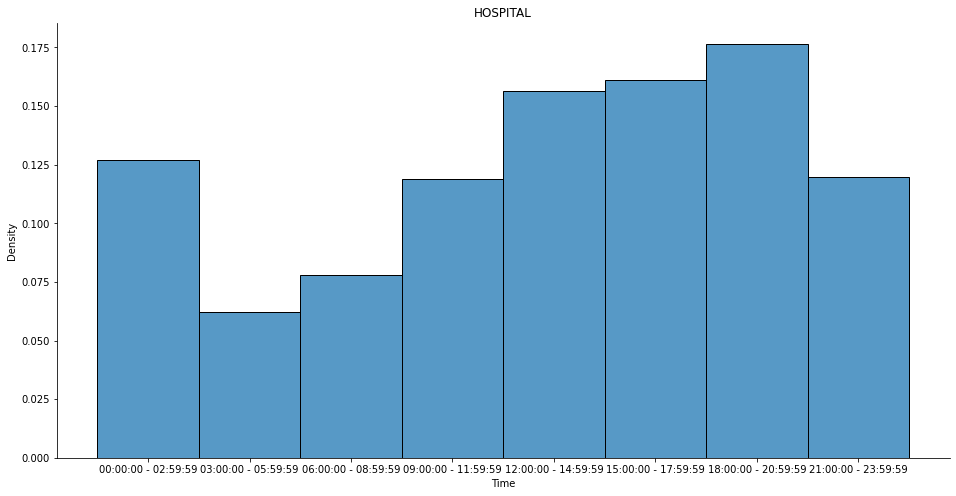

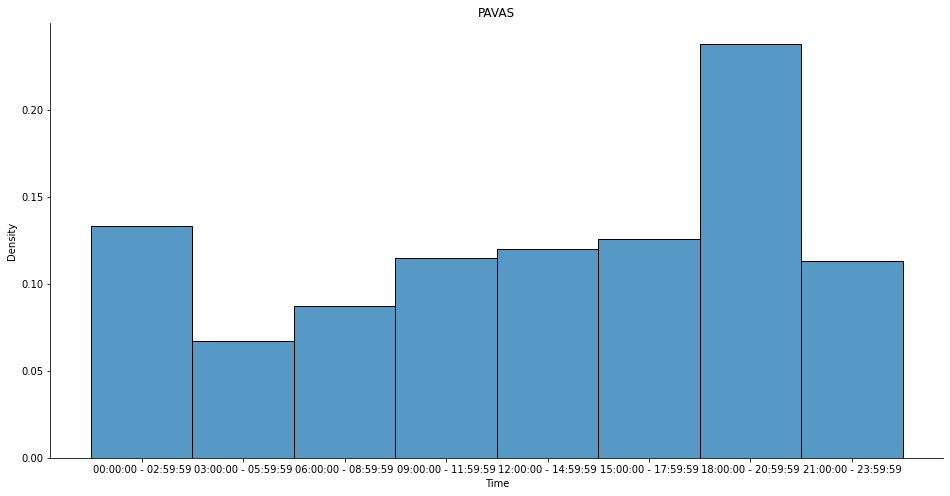

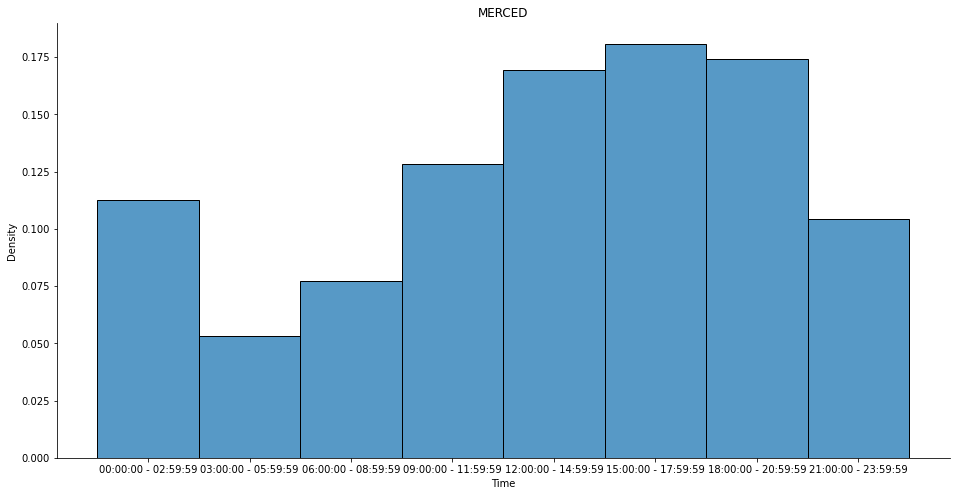

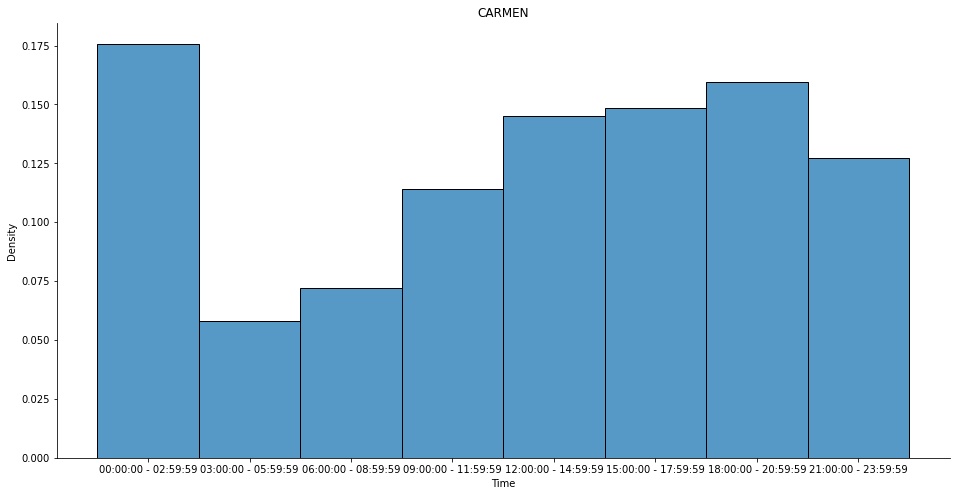

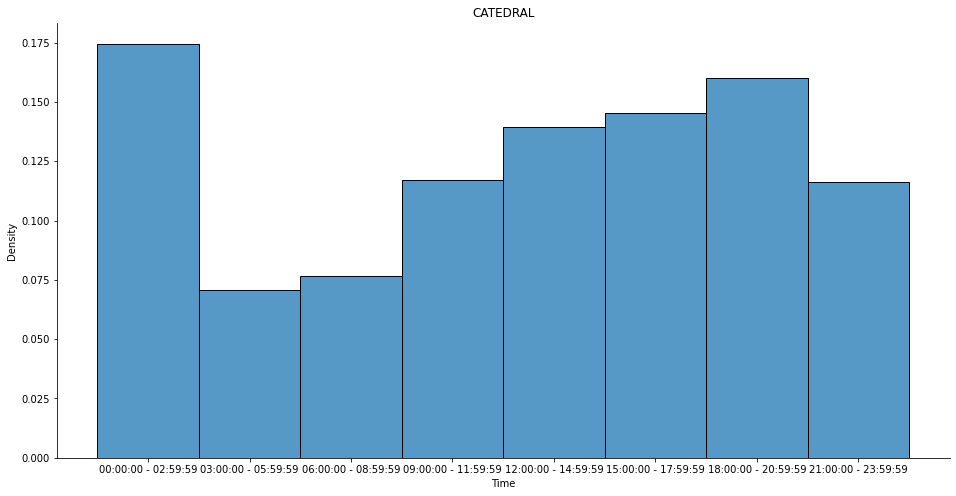

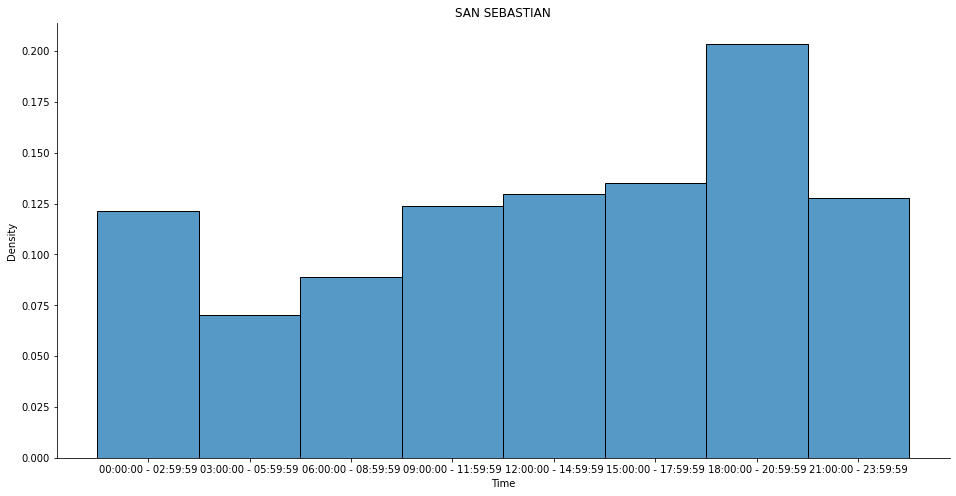

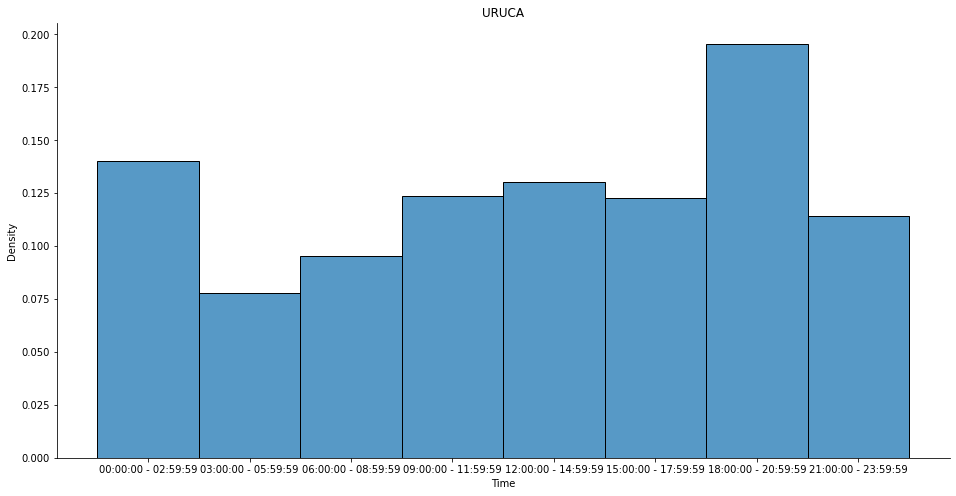

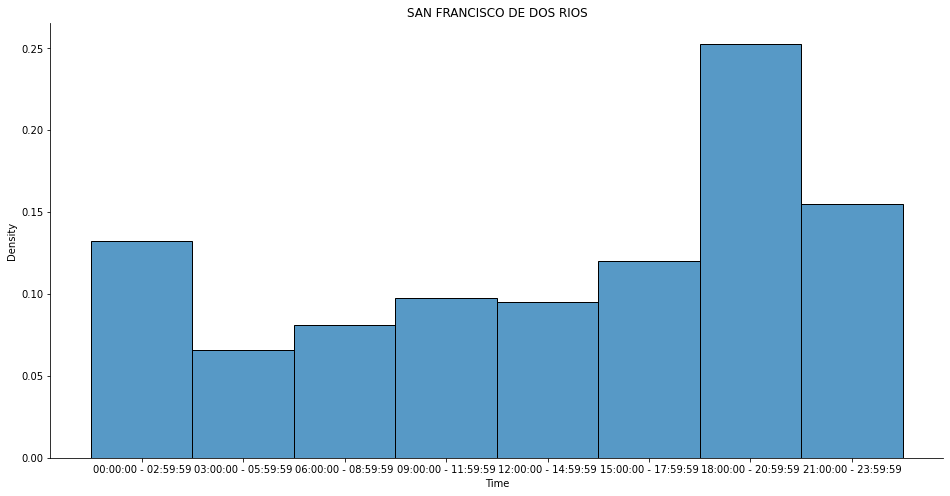

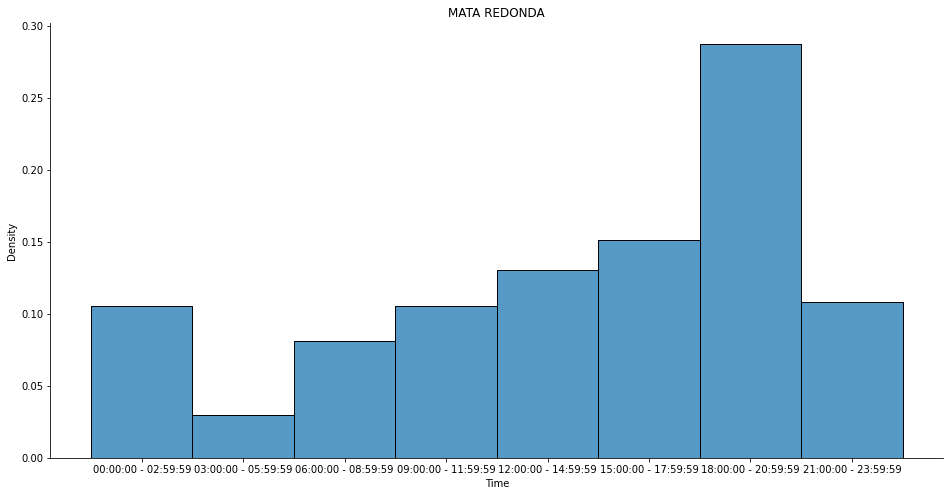

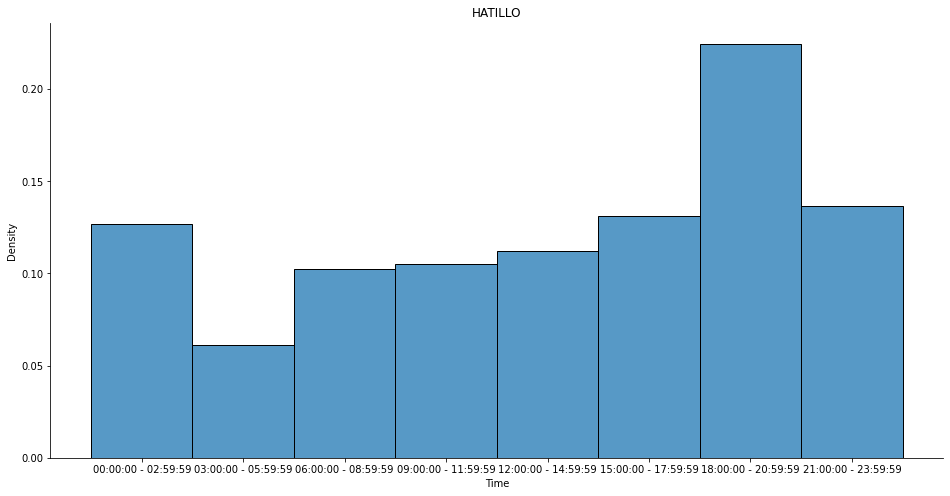

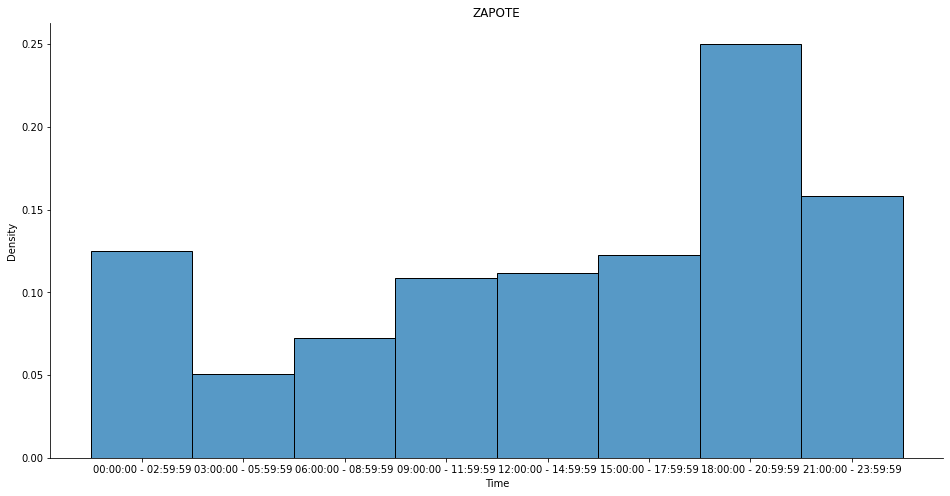

In [ ]:
time_weights = dict()
for district in san_jose_crimes.District.unique():
  aux_df = san_jose_crimes[san_jose_crimes.District == district]

  fig, ax = plt.subplots()
  time_weights[district] = [h.get_height() for h in sns.histplot(data=aux_df.sort_values('Time'), x='Time', stat='density', multiple='stack', ax=ax
  ).patches]
  
  ax.set_title(district)